# IMPORT MODULES

In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.model_selection._search import BaseSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, recall_score, confusion_matrix, precision_score, precision_recall_curve
from sklearn.utils import resample
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as ticker
from sklearn.base import BaseEstimator
from typing import Union, Callable
from joblib import dump, load
from math import sqrt
import matplotlib.cm as cm
import xgboost as xgb


In [270]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray):
    cm = confusion_matrix(y_true, y_pred)

    class_names = ['0', '1']

    plt.figure(figsize=(8, 6), facecolor='#F4F4F4')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True classes')
    plt.xlabel('Predicted classes')
    plt.tight_layout()
    plt.show()
    
def my_classification_report(base_search_cv: BaseSearchCV, X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray):
    print("Best score: {:.3f}".format(base_search_cv.best_score_))
    print("Best params: {}".format(base_search_cv.best_params_))
    pred_devtrain = base_search_cv.predict(X_train)
    pred_val = base_search_cv.predict(X_val)
    print('Cross report on train set:')
    cross_report(estimator=base_search_cv.best_estimator_, X=X_train, y=y_train)
    print("Classification report on train set:\n {}".format(classification_report(y_true=y_train, y_pred=pred_devtrain)));     
    print("Classification report on val set:\n {}".format(classification_report(y_true=y_val, y_pred=pred_val)));
    plot_confusion_matrix(y_true=y_val, y_pred=pred_val)   

def my_classification_report_light(estimator: BaseEstimator, X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray):
    pred_devtrain = estimator.predict(X_train)
    pred_val = estimator.predict(X_val)
    print("Classification report on train set:\n {}".format(classification_report(y_true=y_train, y_pred=pred_devtrain)));
    print("Classification report on val set:\n {}".format(classification_report(y_true=y_val, y_pred=pred_val)));
    plot_confusion_matrix(y_true=y_val, y_pred=pred_val)

def search_report(filename: str, X_val: np.ndarray, y_val:np.ndarray):
    loaded = load(filename)
    model = loaded['model']
    x = loaded['x']
    y = loaded['y']
    my_classification_report(base_search_cv=model, X_train=x, X_val=X_val, y_train=y, y_val=y_val)

def plot_roc_from_tuned(filename: str, label: str, X: np.ndarray, y: np.ndarray):
    model = load(filename)['model']
    fpr, tpr, ts = roc_curve(y_true=y, y_score=model.best_estimator_.predict_proba(X)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=label+' (area={:.3f},cvs={:.3f})'.format(roc_auc,model.best_score_))
    
def plot_pr_from_tuned(filename: str, label: str, X: np.ndarray, y: np.ndarray):
    model = load(filename)['model']
    pr, rc, ts = precision_recall_curve(y_true=y, probas_pred=model.best_estimator_.predict_proba(X)[:,1])
    plt.plot(rc, pr, label=label)
    
def cross_report(estimator: BaseEstimator, X: np.ndarray, y: np.ndarray, cv=5):
    scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
    results = cross_validate(estimator=estimator, scoring=scoring, X=X, y=y, cv=cv)
    print('\tAccuracy:\t{:.4f}'.format(results['test_accuracy'].mean()))
    print('\tF1-score:\t{:.4f}'.format(results['test_f1'].mean()))
    print('\tPrecision:\t{:.4f}'.format(results['test_precision'].mean()))
    print('\tRecall:\t\t{:.4f}'.format(results['test_recall'].mean()))
    print('\tROC_AUC:\t{:.4f}'.format(results['test_roc_auc'].mean()))
    

# EDA
Carico il dataset e formulo le prime osservazioni

In [271]:
#load the dataset
df = pd.read_csv("credit_risk_dataset.csv")

In [272]:
#first look
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


The dataset, comprising approximately 30000 rows, is quite extensive.

The target variable is 'loan_status', with the following values:
- '1': default status, indicating an insolvent customer
- '0': regular payments


Some features have a small portion of rows with NaN values.

In [273]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


The features have significantly different scales. We go from the loan_status, which has an average value of approximately 0.22, to the person_income, which reaches magnitudes of $10^3$-$10^6$.

The target is distributed as follows:

In [274]:
num_target_1 = (df.loan_status==1).sum()
num_target_0 = (df.loan_status==0).sum()
print("Amount of loans being default: {}".format(num_target_1))
print("Amount of loans not being default: {}".format(num_target_0))

Amount of loans being default: 7108
Amount of loans not being default: 25473


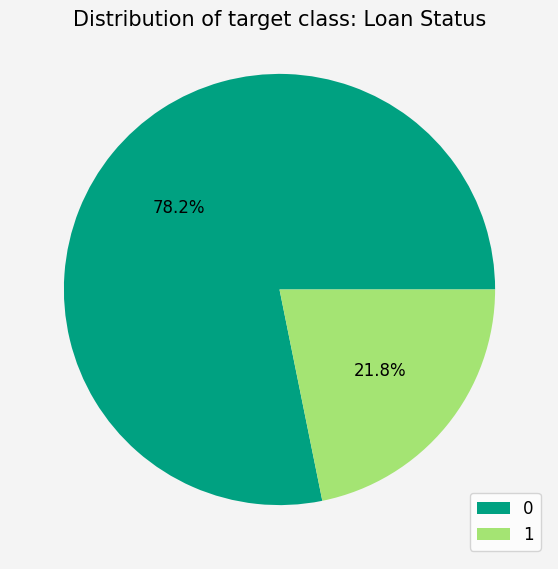

In [275]:
#plot on a pie chart
values = [num_target_0, num_target_1]
plt.figure(figsize=[7,7], facecolor='#F4F4F4')
_, _, text = plt.pie(values, autopct='%.1f%%', colors=['#00A181','#A4E473'])
plt.setp(text, fontsize=12)
plt.legend(['0', '1'], fontsize=12, loc='lower right')
plt.text(0.5, 1, "Distribution of target class: Loan Status", fontsize=15, ha='center', va='center', transform=plt.gca().transAxes);


We can immediately see that:
1. There are two columns with NaN values:
    - person_emp_length (employment length in years)
    - loan_int_rate (interest rate of the loan)
2. It is suspected that there may be some outliers:
    - person_age has a max value of 144 years
    - person_emp_length has a max value of 123 years
    - moreover, the remaining features exhibit maximum values well above the 75th percentile 
3. Target class is quite unbalanced, with a proportion of 2:7. 

We can split the features in numericals, ordinals and categoricals as follows:

In [276]:
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
#ordinal features are categorical features to be ordinal-encoded
ordinal_features = ['loan_grade']
categorical_features = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
print('Numerical features: ', numerical_features)
print('Ordinal features: ', ordinal_features)
print('Categorical features: ', categorical_features)

Numerical features:  ['person_age', 'person_income', 'person_emp_length', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Ordinal features:  ['loan_grade']
Categorical features:  ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']


## Numerical features

Let's have a look at the numerical features, paying special attention to those that appear to have potential outliers.

### Person age

This feature represents the age of the customers. We have already identified a suspicious maximum value of 144 years.

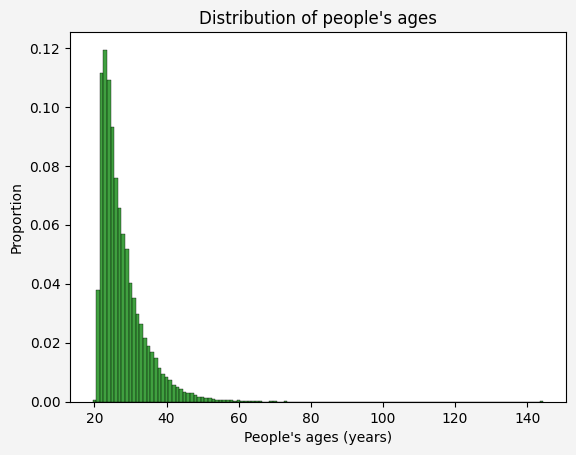

In [277]:
#plot the distribution
plt.figure(facecolor='#F4F4F4')
sns.histplot(data=df, x='person_age', stat='proportion', discrete=True, color='g')
plt.title("Distribution of people's ages")
plt.xlabel("People's ages (years)");

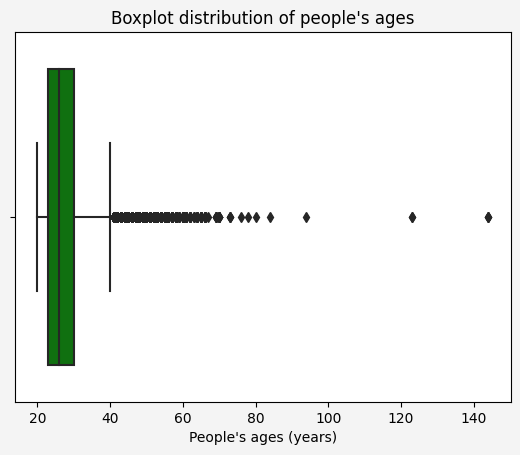

In [278]:
#plot a boxplot to enlight outliers
plt.figure(facecolor='#F4F4F4')
sns.boxplot(data=df, x='person_age', color='g')
plt.title("Boxplot distribution of people's ages")
plt.xlabel("People's ages (years)");

In the two graphs, it is clearly visible that the distribution has a long right tail. There are some outliers above 40 years, but not all of them represent abnormal values.

Indeed, considering the meaning of the feature in the dataset, truncating at 70 years could be a reasonable value.

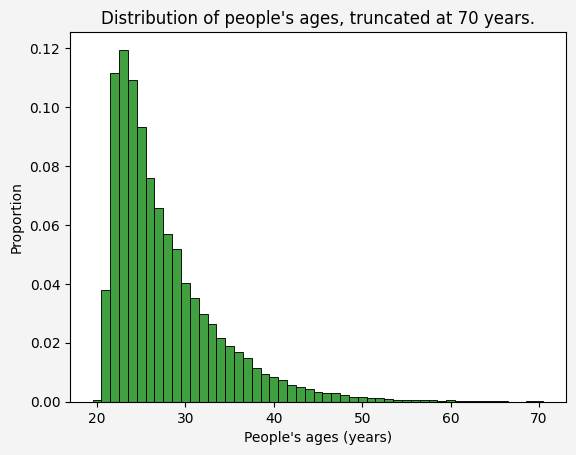

In [279]:
#plot a truncated distribution
plt.figure(facecolor='#F4F4F4')
sns.histplot(data=df[df.person_age <= 70], x='person_age', stat='proportion', discrete=True, color='g')
plt.title("Distribution of people's ages, truncated at 70 years.")
plt.xlabel("People's ages (years)");

If I decide to proceed with an arbitrary cutoff around 70 years, the distribution would still remain quite skewed, but I can treat it using a robust scaling.

### Employment length

This feature represents the years of work experience of the customers. Once again, we have already encountered an anomalous maximum value of 123 years.

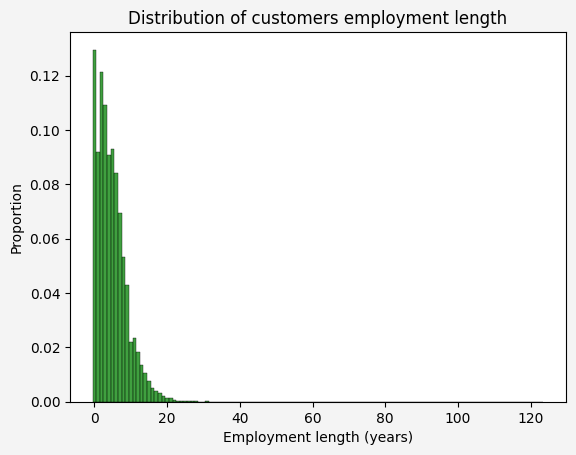

In [280]:
plt.figure(facecolor='#F4F4F4')
sns.histplot(data=df, x='person_emp_length', stat='proportion', discrete=True, color='g')
plt.title("Distribution of customers employment length")
plt.xlabel("Employment length (years)");

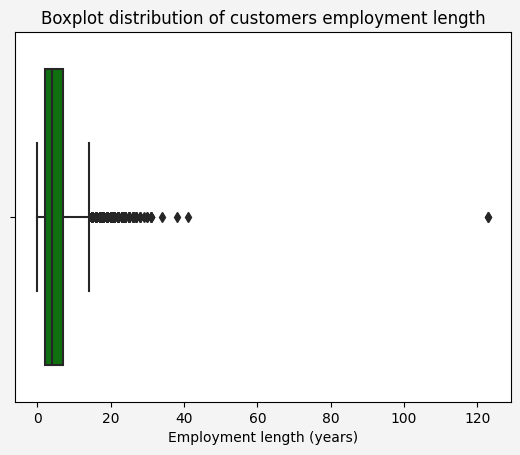

In [281]:

plt.figure(facecolor='#F4F4F4')
sns.boxplot(data=df, x='person_emp_length', color='g')
plt.title("Boxplot distribution of customers employment length")
plt.xlabel("Employment length (years)");

In the above graph, we can clearly see many outliers values above 20.


The most effective approach for cleaning this data may consist in manually removing the highest values - say above 40 -, because the others are not impossible values. Additionally, remaining outliers can be addressed by applying a robust scaler.

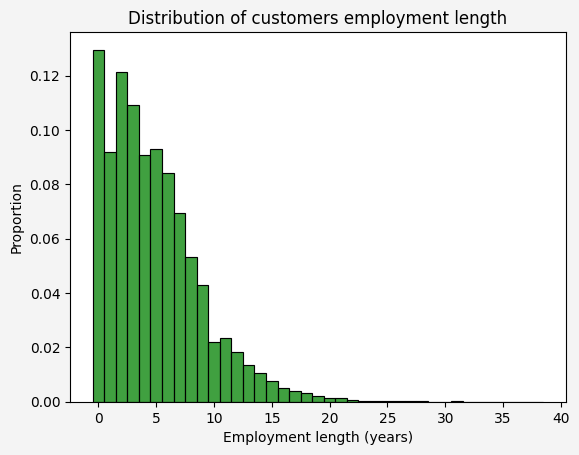

In [282]:
plt.figure(facecolor='#F4F4F4')
sns.histplot(data=df[df.person_emp_length <=40], x='person_emp_length', stat='proportion', discrete=True, color='g')
plt.title("Distribution of customers employment length")
plt.xlabel("Employment length (years)");

### Other features

While we have examined 'person_income' and 'person_emp_length' in detail, as it is easy to identify outliers in age and career duration, for the other numerical features, we can simply take a quick look and decide later on how to handle any outliers.

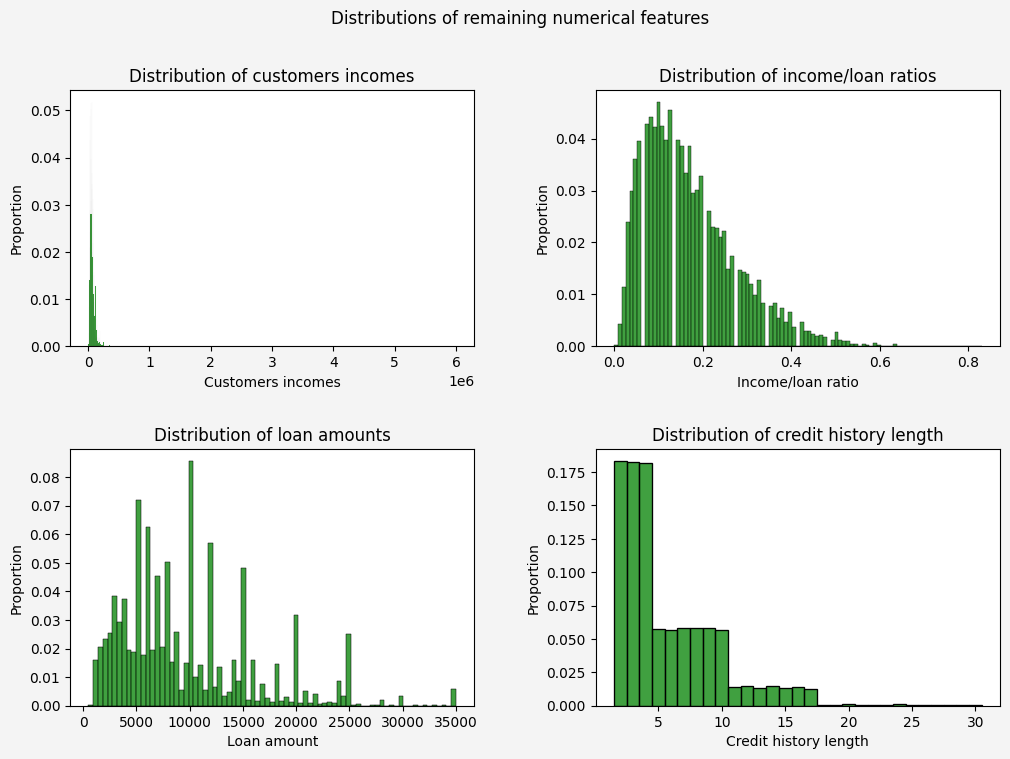

In [283]:
fig, axs = plt.subplots(2,2, figsize=[12,8], facecolor='#F4F4F4')
fig.suptitle("Distributions of remaining numerical features")
sns.histplot(df.person_income, ax=axs[0,0], color='g', stat='proportion')
axs[0,0].set_xlabel('Customers incomes')
axs[0,0].set_title("Distribution of customers incomes")
sns.histplot(df.loan_percent_income, ax=axs[0,1], color='g', stat='proportion')
axs[0,1].set_xlabel('Income/loan ratio')
axs[0,1].set_title("Distribution of income/loan ratios")
sns.histplot(df.loan_amnt, ax=axs[1,0], color='g', stat='proportion')
axs[1,0].set_xlabel('Loan amount')
axs[1,0].set_title("Distribution of loan amounts")
sns.histplot(df.cb_person_cred_hist_length, ax=axs[1,1], color='g', stat='proportion', discrete=True)
axs[1,1].set_xlabel('Credit history length')
axs[1,1].set_title("Distribution of credit history length")

plt.subplots_adjust(hspace=0.4, wspace=0.3)

It emerged that each numerical feature displays some outliers, especially for the incomes, which may not necessarily appear to be anomalous data.

So, it seems that the most suitable approach would be to start with a robust scaler. Then, we need to assess whether the outliers will still pose a problem.


## NaN values


There are two columns with null values:

In [284]:
pel_nan = df.person_emp_length.isna().sum()
lir_nan = df.loan_int_rate.isna().sum()
print("person_emp_length has {} ({:.3}%) nan values".format(pel_nan, 100.*pel_nan/len(df)))
print("loan_int_rate has {} ({:.3}%) nan values".format(lir_nan, 100*lir_nan/len(df)))

person_emp_length has 895 (2.75%) nan values
loan_int_rate has 3116 (9.56%) nan values


I prefer not to impute fake data in the dataset, especially if there is enough data to remove some entries.

However, the null values in the loan_int_rate represent almost 10% of the dataset. Therefore, I will first verify that the target distribution is well represented before proceeding.

In [285]:
print("\nDistribution of loan_int_rate NaN:")
df[df.loan_int_rate.isna()]['loan_status'].value_counts(normalize=True)


Distribution of loan_int_rate NaN:


loan_status
0    0.793325
1    0.206675
Name: proportion, dtype: float64

## Shares of target classes over numerical features

Let's examine how the target is distributed within each numerical feature.

In [286]:
#define a function for plotting every numerical feature by passing different values to common_norm parameter
def histplotNumericalFeatures(features: pd.DataFrame, target: Union[pd.Series, np.ndarray], common_norm: bool = False):

    df = features.copy()
    df['loan_status'] = target
    
    #initizalize subplots
    fig, axs = plt.subplots(4,3, figsize=[20,15])
    fig.set_facecolor('#F4F4F4')

    #set title
    if common_norm:
        fig.suptitle("Distribution of numerical features differentiated by loan status.")
    else:
        fig.suptitle("Distribution of numerical features differentiated by loan status. \nIn each graph, the two distributions are independently normalized.")
    #plt.subplots_adjust(top=0.7)
    #plt.title('\n', y=0.9)

    #loan_int_rate
    if 'loan_int_rate' in features: 
        sns.histplot(data=df, x='loan_int_rate', hue='loan_status', stat='proportion', discrete=False, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[0,0])

    #loan_percent_income
    if 'loan_percent_income' in features: 
        sns.histplot(data=df, x='loan_percent_income', hue='loan_status', stat='proportion', discrete=False, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[0,1])

    #cb_person_cred_hist_length
    if 'cb_person_cred_hist_length' in features: 
        sns.histplot(data=df, x='cb_person_cred_hist_length', hue='loan_status', stat='proportion', discrete=True, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[0,2])

    #person_age full
    if 'person_age' in features: 
        sns.histplot(data=df, x='person_age', hue='loan_status', stat='proportion', discrete=True, common_norm=False, multiple='layer', element='step', fill=False, ax=axs[1,0])

    #person_age truncated
    if 'person_age' in features:
        sns.histplot(data=df[df.person_age <= 70], x='person_age', hue='loan_status', stat='proportion', discrete=True, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[1,1])
        axs[1,1].set_xlabel("person_age (trunc. at 70)")

    #person_income full
    if 'person_income' in features:
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-3, 3))
        axs[2,0].xaxis.set_major_formatter(formatter)
        sns.histplot(data=df, x='person_income', hue='loan_status', stat='proportion', discrete=False, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[2,0])

    #person_income trucanted
    if 'person_income' in features:
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-3, 3))
        axs[2,1].xaxis.set_major_formatter(formatter)
        sns.histplot(data=df[df.person_income < 3e5], x='person_income', hue='loan_status', stat='proportion', discrete=False, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[2,1])
    axs[2,1].set_xlabel("person_income (trunc. at 3e5)")

    #person_emp_length full
    if 'person_emp_length' in features:
        sns.histplot(data=df, x='person_emp_length', hue='loan_status', stat='proportion', discrete=True, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[3,0])

    #person_emp_length truncated
    if 'person_emp_length' in features:
        sns.histplot(data=df[df.person_emp_length <= 40], x='person_emp_length', hue='loan_status', stat='proportion', discrete=True, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[3,1])
        axs[3,1].set_xlabel("person_emp_length (trunc. at 40)")

    #delete empty subplots
    fig.delaxes(axs[1,2])
    fig.delaxes(axs[2,2])
    fig.delaxes(axs[3,2])

    #increase space between subplots
    plt.tight_layout()

    plt.show()

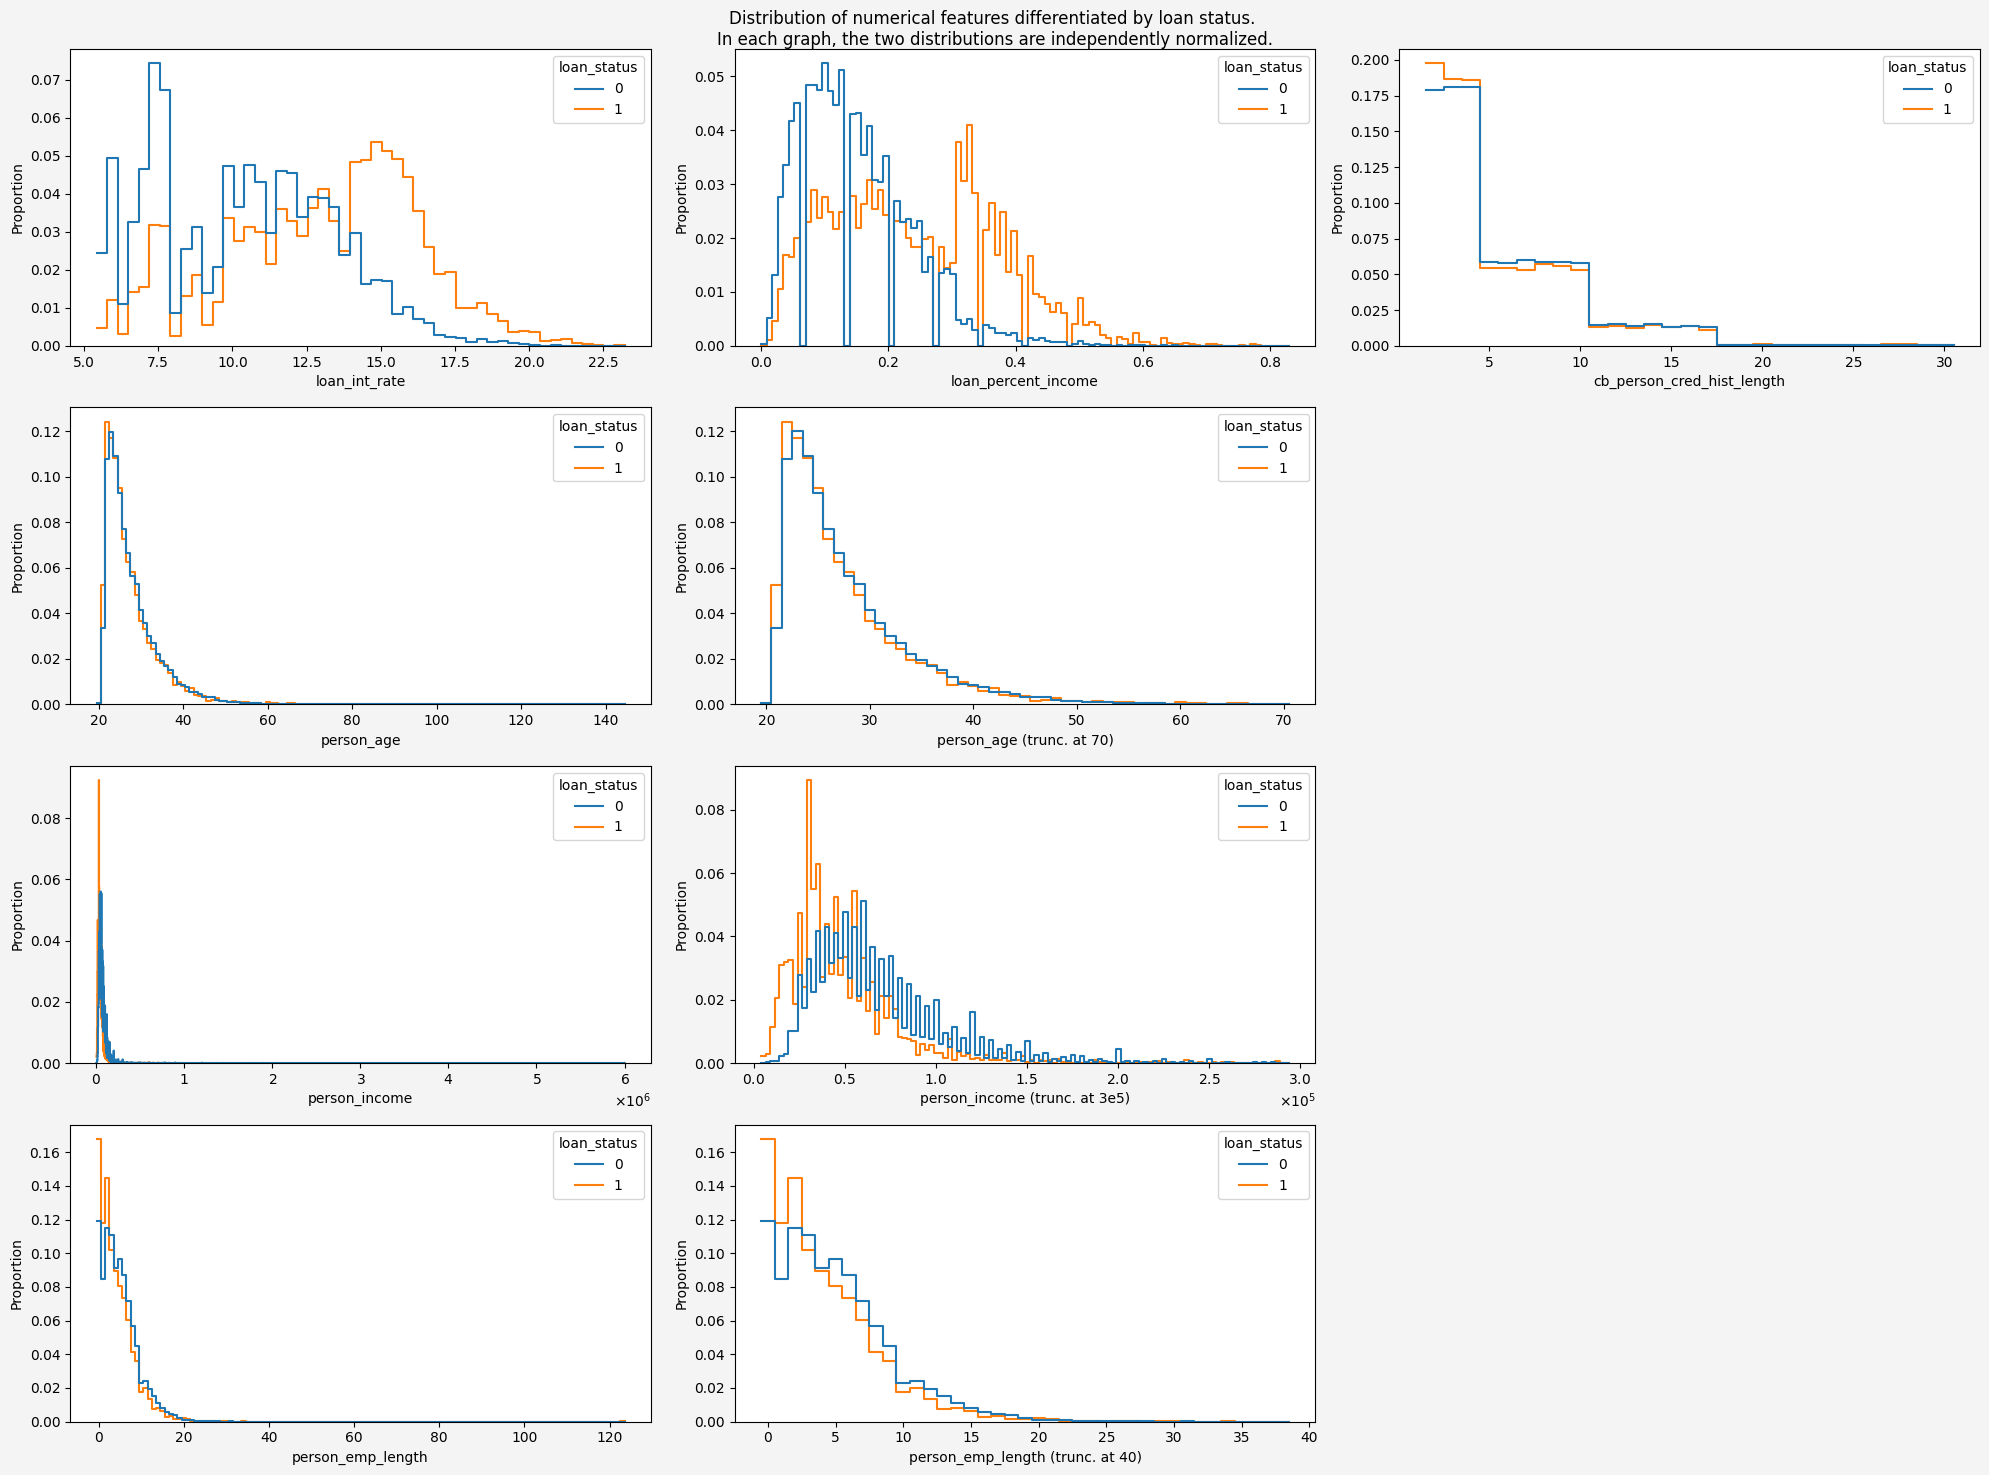

In [287]:
histplotNumericalFeatures(df[numerical_features], df['loan_status'], common_norm=False)

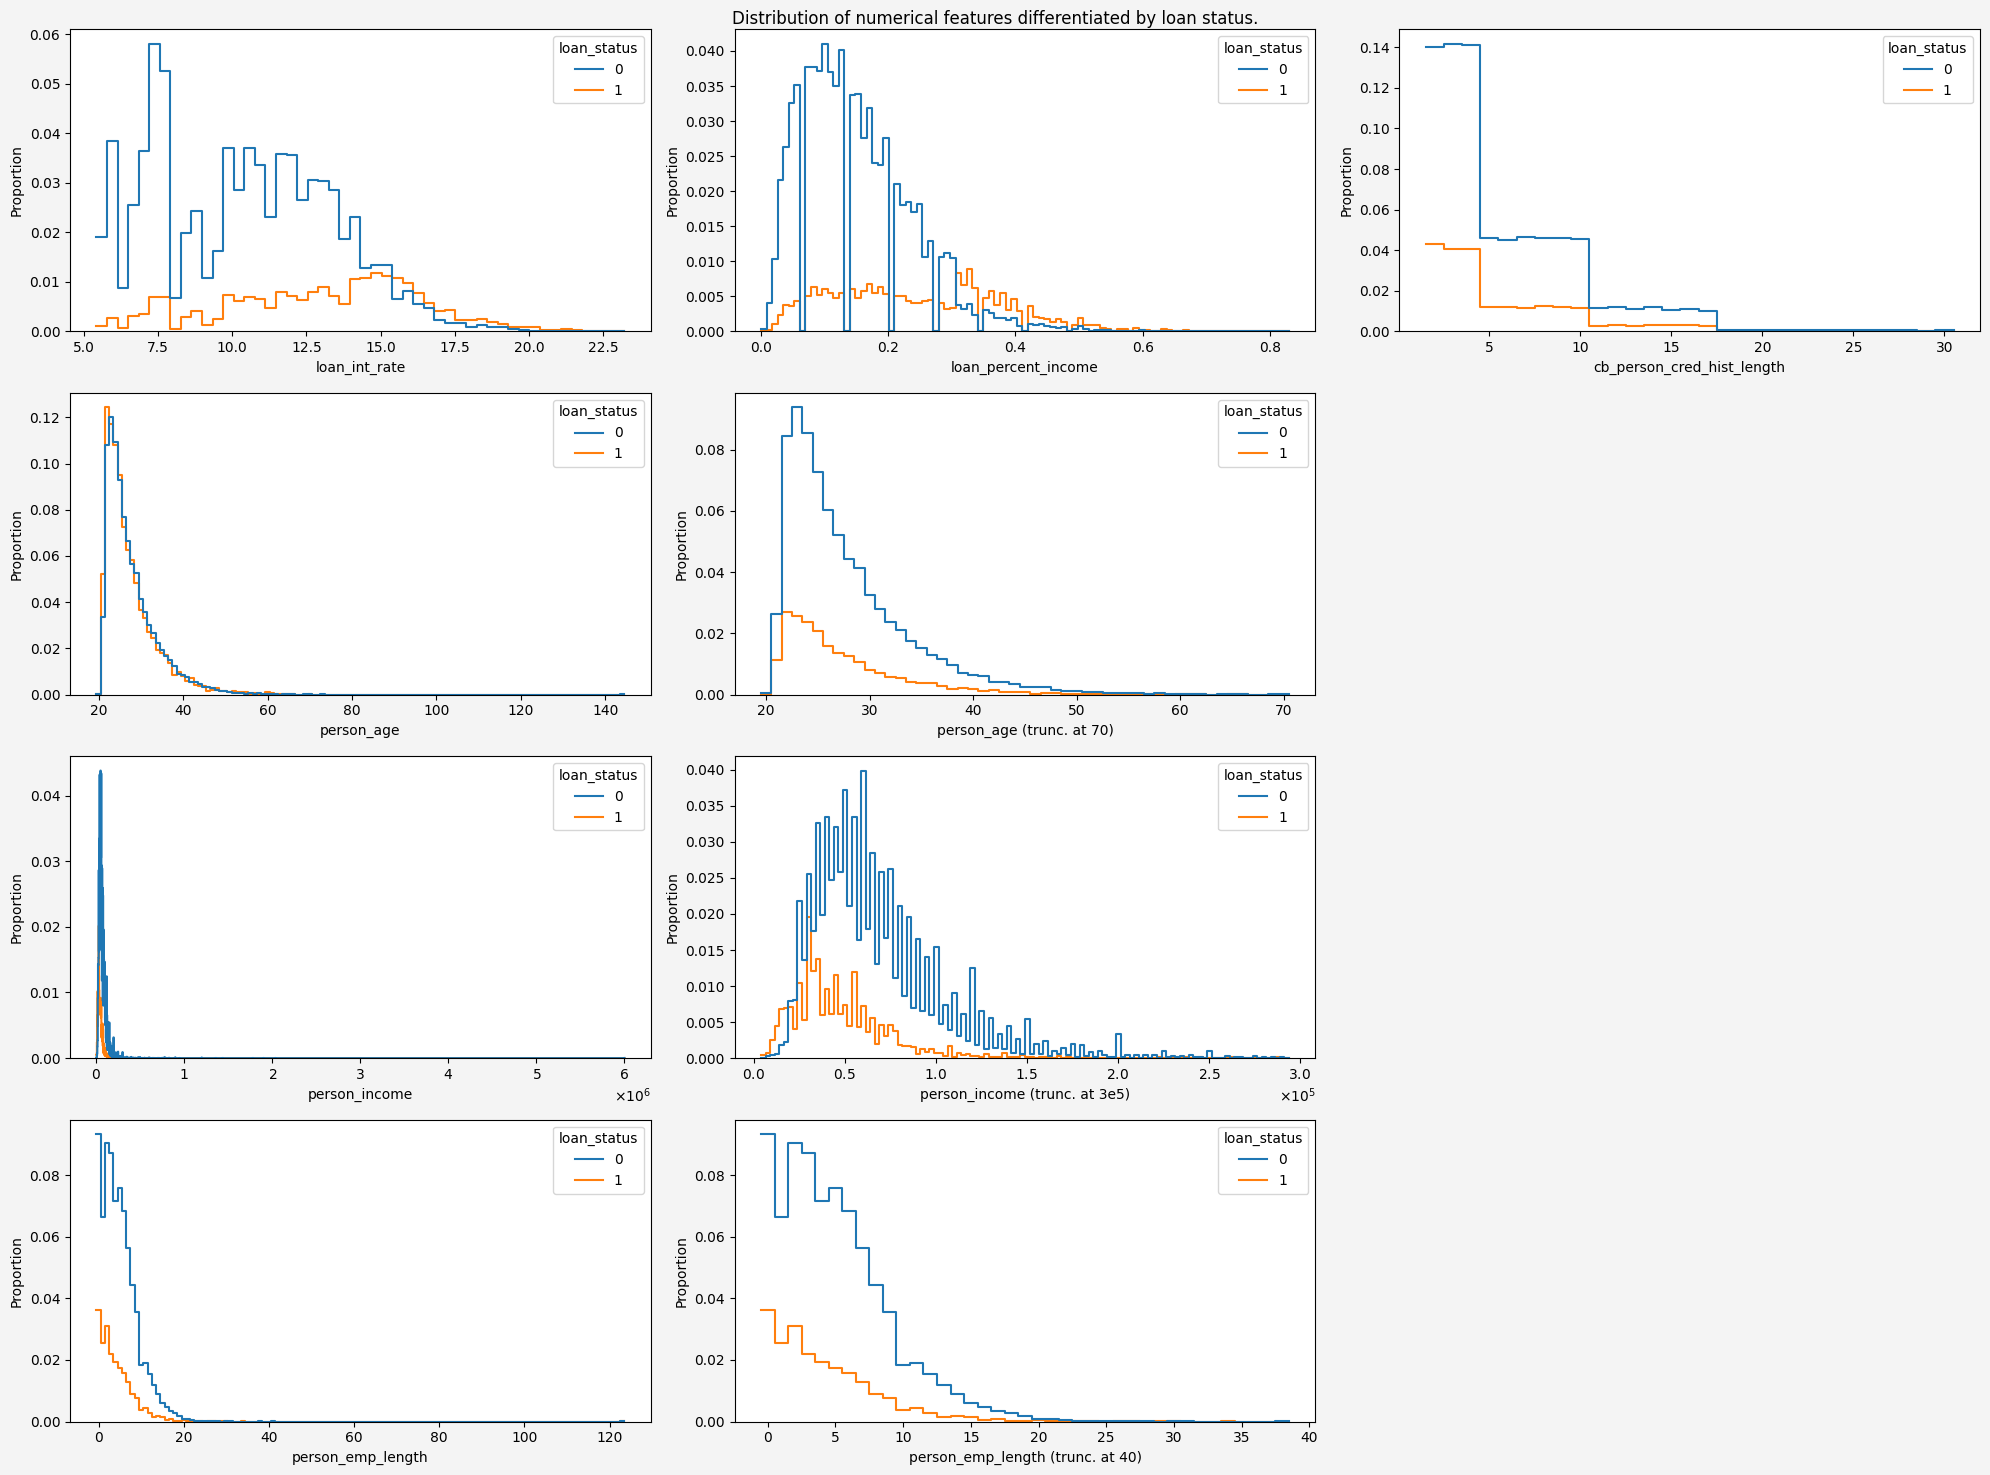

In [288]:
histplotNumericalFeatures(df[numerical_features], df['loan_status'], common_norm=True)

It is clear that some features have a strong correlation with the target classes, while others appear to be entirely indifferent.

Indeed, the most notable ones are loan_int_rate and loan_percent_income.

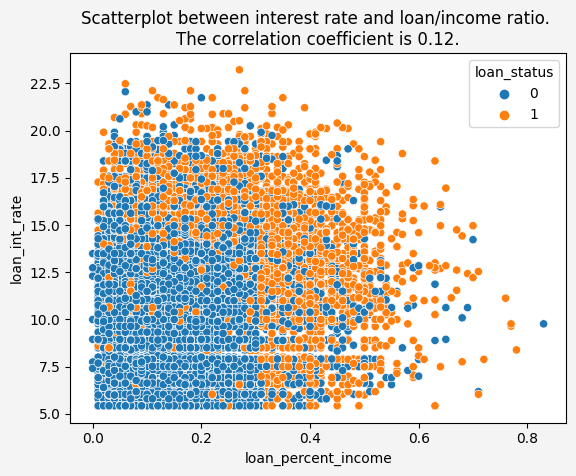

In [289]:
#check correlation between loan_percent_income and loan_int_rate
df_temp = df[~df.loan_int_rate.isna()]
plt.figure(facecolor='#F4F4F4')
corr = np.corrcoef(df_temp.loan_int_rate, df_temp.loan_percent_income)
sns.scatterplot(data=df, x='loan_percent_income', y='loan_int_rate', hue='loan_status');
plt.title("Scatterplot between interest rate and loan/income ratio. \nThe correlation coefficient is {:.2}.".format(corr[0,1]));

Furthermore, it can be observed that these features, loan_int_rate and loan_percent_income, are not correlated with each other. Hence, they could serve as excellent features for our predictive model.

However, it appears that the target variable is well correlated with average high values of both these features.

## Shares of target classes over categorical features

Let's examine how the target is distributed within each categorical feature.

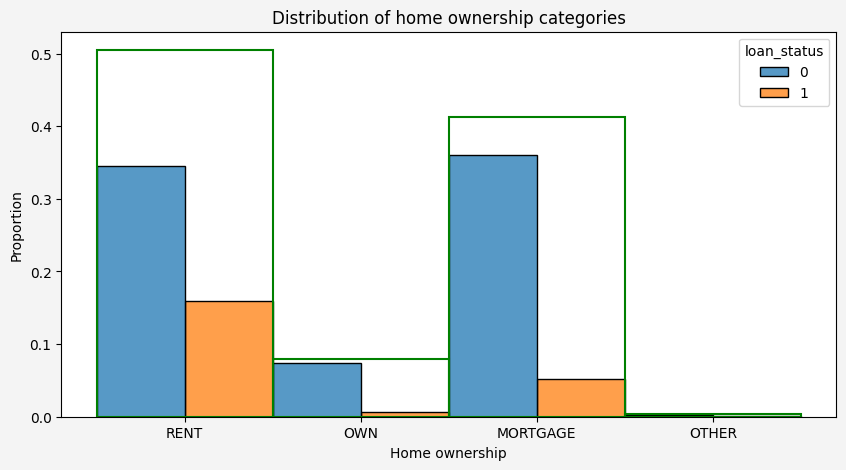

In [290]:
#home ownership
plt.figure(figsize=[10,5], facecolor='#F4F4F4')
plt.title("Distribution of home ownership categories")
plt.xlabel('Home ownership')
sns.histplot(data=df, x='person_home_ownership', hue='loan_status', multiple='dodge', stat='proportion', common_norm=True);
sns.histplot(data=df, x='person_home_ownership', stat='proportion', color='green', fill=False);

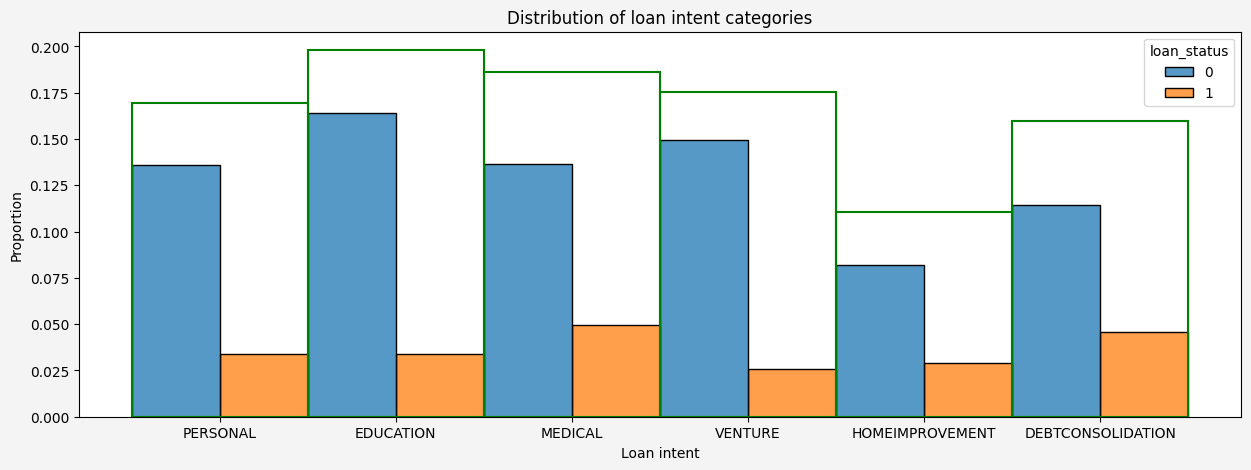

In [291]:
#loan intent
plt.figure(figsize=[15,5], facecolor='#F4F4F4')
plt.title("Distribution of loan intent categories")
plt.xlabel('Loan intent')
sns.histplot(data=df, x='loan_intent', hue='loan_status', multiple='dodge', stat='proportion', common_norm=True);
sns.histplot(data=df, x='loan_intent', stat='proportion', color='green', fill=False);

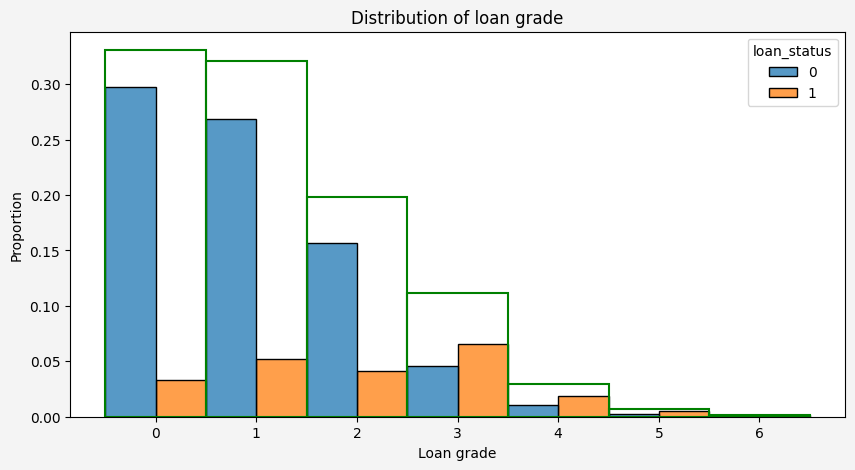

In [292]:
#loan grade
df_temp = df.copy()
oe = OrdinalEncoder()
df_temp['loan_grade'] = oe.fit_transform(np.array(df['loan_grade']).reshape(-1,1))

plt.figure(figsize=[10,5], facecolor='#F4F4F4')
plt.title("Distribution of loan grade")
plt.xlabel('Loan grade')
sns.histplot(data=df_temp, x='loan_grade', hue='loan_status', multiple='dodge', stat='proportion', common_norm=True, discrete=True);
sns.histplot(data=df_temp, x='loan_grade', stat='proportion', color='green', fill=False, discrete=True);

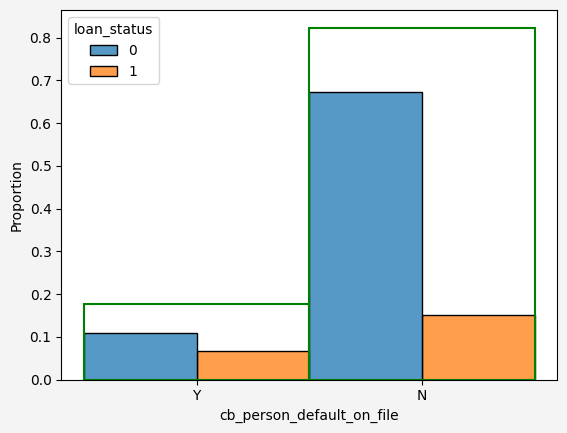

In [293]:
#historical default
plt.figure(facecolor='#F4F4F4')
sns.histplot(data=df_temp, x='cb_person_default_on_file', hue='loan_status', multiple='dodge', stat='proportion', common_norm=True, discrete=True);
sns.histplot(data=df, x='cb_person_default_on_file', stat='proportion', color='green', fill=False, discrete=True);

From the graphs, several patterns can be observed that are not surprising:
- In the case of home ownership types, the category that appears to carry more weight in default risk is renting.
- Regarding loan intents, credits for medical expenses and debt consolidation appear to be the riskiest.
- Lastly, there is evidently a high risk in extending credits to individuals who have already demonstrated poor payment history in the past.

In [294]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

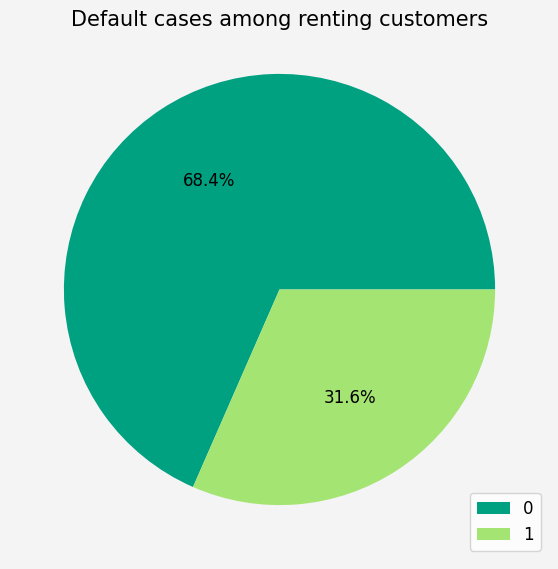

In [295]:
#plot on a pie chart
num_target_1 = (df[df['person_home_ownership']=='RENT'].loan_status==1).sum()
num_target_0 = (df[df['person_home_ownership']=='RENT'].loan_status==0).sum()
values = [num_target_0, num_target_1]
plt.figure(figsize=[7,7], facecolor='#F4F4F4')
_, _, text = plt.pie(values, autopct='%.1f%%', colors=['#00A181','#A4E473'])
plt.setp(text, fontsize=12)
plt.legend(['0', '1'], fontsize=12, loc='lower right')
plt.text(0.5, 1, "Default cases among renting customers", fontsize=15, ha='center', va='center', transform=plt.gca().transAxes);

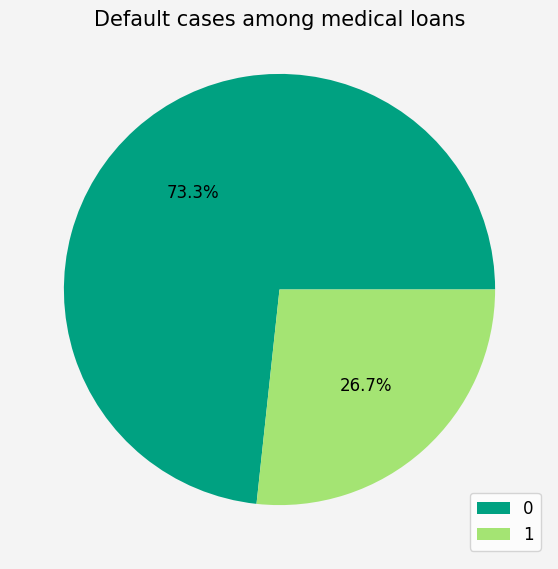

In [296]:
#plot on a pie chart
num_target_1 = (df[df['loan_intent']=='MEDICAL'].loan_status==1).sum()
num_target_0 = (df[df['loan_intent']=='MEDICAL'].loan_status==0).sum()
values = [num_target_0, num_target_1]
plt.figure(figsize=[7,7], facecolor='#F4F4F4')
_, _, text = plt.pie(values, autopct='%.1f%%', colors=['#00A181','#A4E473'])
plt.setp(text, fontsize=12)
plt.legend(['0', '1'], fontsize=12, loc='lower right')
plt.text(0.5, 1, "Default cases among medical loans", fontsize=15, ha='center', va='center', transform=plt.gca().transAxes);

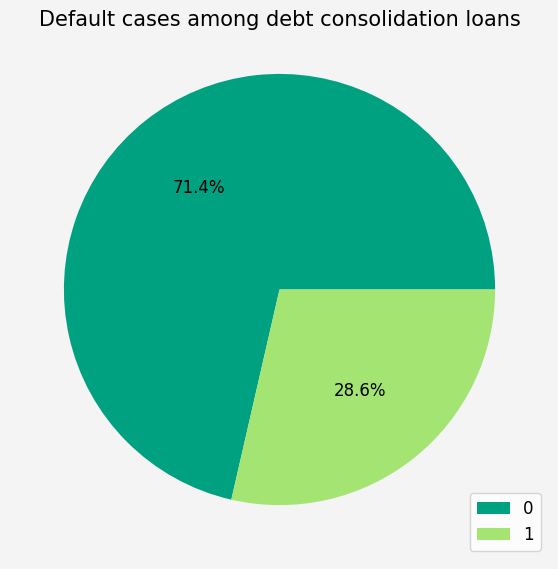

In [297]:
#plot on a pie chart
num_target_1 = (df[df['loan_intent']=='DEBTCONSOLIDATION'].loan_status==1).sum()
num_target_0 = (df[df['loan_intent']=='DEBTCONSOLIDATION'].loan_status==0).sum()
values = [num_target_0, num_target_1]
plt.figure(figsize=[7,7], facecolor='#F4F4F4')
_, _, text = plt.pie(values, autopct='%.1f%%', colors=['#00A181','#A4E473'])
plt.setp(text, fontsize=12)
plt.legend(['0', '1'], fontsize=12, loc='lower right')
plt.text(0.5, 1, "Default cases among debt consolidation loans", fontsize=15, ha='center', va='center', transform=plt.gca().transAxes);

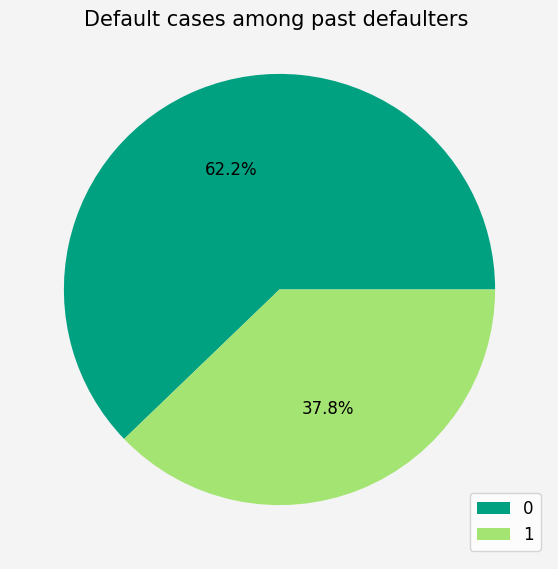

In [298]:
#plot on a pie chart
num_target_1 = (df[df['cb_person_default_on_file']=='Y'].loan_status==1).sum()
num_target_0 = (df[df['cb_person_default_on_file']=='Y'].loan_status==0).sum()
values = [num_target_0, num_target_1]
plt.figure(figsize=[7,7], facecolor='#F4F4F4')
_, _, text = plt.pie(values, autopct='%.1f%%', colors=['#00A181','#A4E473'])
plt.setp(text, fontsize=12)
plt.legend(['0', '1'], fontsize=12, loc='lower right')
plt.text(0.5, 1, "Default cases among past defaulters ", fontsize=15, ha='center', va='center', transform=plt.gca().transAxes);

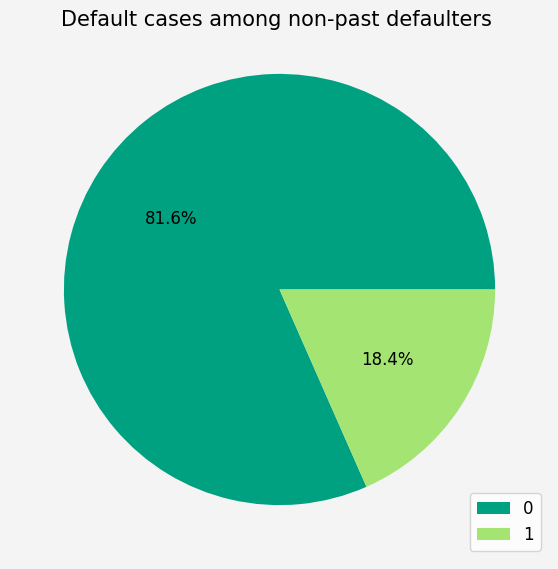

In [299]:
#plot on a pie chart
num_target_1 = (df[df['cb_person_default_on_file']=='N'].loan_status==1).sum()
num_target_0 = (df[df['cb_person_default_on_file']=='N'].loan_status==0).sum()
values = [num_target_0, num_target_1]
plt.figure(figsize=[7,7], facecolor='#F4F4F4')
_, _, text = plt.pie(values, autopct='%.1f%%', colors=['#00A181','#A4E473'])
plt.setp(text, fontsize=12)
plt.legend(['0', '1'], fontsize=12, loc='lower right')
plt.text(0.5, 1, "Default cases among non-past defaulters ", fontsize=15, ha='center', va='center', transform=plt.gca().transAxes);

# Data cleaning

## Impossible outliers
Let's remove outliers that are due to obvious data errors. 

We have identified two features that contain such data:
- person_age
- person_emp_length

In [300]:
df_cleaned = df.copy()

In [301]:
#check if there are records with person_emp_length > person_age
df[df.person_age <= df.person_emp_length]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


In [302]:
indexes_to_remove = df[df.person_age <= df.person_emp_length].index
df_cleaned = df.drop(indexes_to_remove, axis=0)
df_cleaned = df_cleaned.reindex()

print("Removed {} rows such that person_emp_length > person_age.".format(len(df)-len(df_cleaned)))

Removed 2 rows such that person_emp_length > person_age.


Now we can remove the customers who are above 70 years of age, as there are only a few cases overall.

In [303]:
print("Removing {} rows such that people's age is above 70 years.".format(len(df_cleaned[df_cleaned.person_age >= 70])))
df_cleaned = df_cleaned[df_cleaned.person_age <= 70]

Removing 20 rows such that people's age is above 70 years.


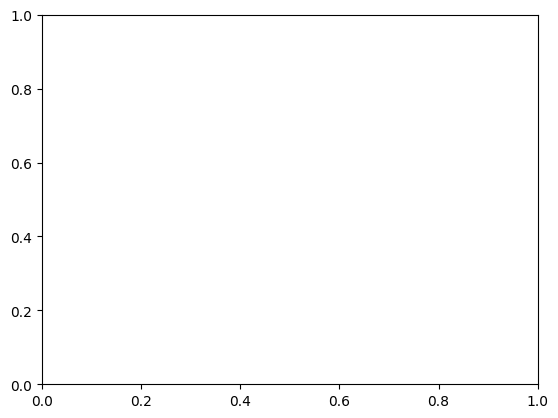

In [304]:
#how many outliers for person_emp_length?
sns.histplot(data=df_cleaned[df_cleaned.person_emp_length >= 50], x='person_emp_length', hue='loan_status', discrete=True, common_norm=False, multiple='layer', element='step', fill=True);

It looks like we've already removed person_emp_length impossible outliers.

Regarding the others numerical features, we can't say wheter the outliers are anomalous. Thus we'll treat them later by performing a robust scaler.

## NaN values

Let's repeat the NaN analisys on the cleaned dataset

In [305]:
pel_nan = df_cleaned.person_emp_length.isna().sum()
lir_nan = df_cleaned.loan_int_rate.isna().sum()
print("person_emp_length has {} ({:.1f}%) nan values".format(pel_nan, 100.*pel_nan/len(df_cleaned)))
print("loan_int_rate has {} ({:.1f}%) nan values".format(lir_nan, 100*lir_nan/len(df_cleaned)))

person_emp_length has 895 (2.7%) nan values
loan_int_rate has 3113 (9.6%) nan values


In [306]:
print("Size of the cleaned dataset: {}".format(len(df_cleaned)))

print("\nDistribution of loan_int_rate NaNs:")
df_cleaned[df_cleaned.loan_int_rate.isna()]['loan_status'].value_counts(normalize=True)


Size of the cleaned dataset: 32566

Distribution of loan_int_rate NaNs:


loan_status
0    0.793126
1    0.206874
Name: proportion, dtype: float64

The dataset is big enough to remove all the NaN rows.

In [307]:
df_cleaned.drop(df_cleaned[df_cleaned.loan_int_rate.isna()].index, axis=0, inplace=True)
df_cleaned.drop(df_cleaned[df_cleaned.person_emp_length.isna()].index, axis=0, inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

In [308]:
#check whether there are other NaN rows
df_cleaned.isna().any()

person_age                    False
person_income                 False
person_home_ownership         False
person_emp_length             False
loan_intent                   False
loan_grade                    False
loan_amnt                     False
loan_int_rate                 False
loan_status                   False
loan_percent_income           False
cb_person_default_on_file     False
cb_person_cred_hist_length    False
dtype: bool

## Checking target distribution after cleaning

In [309]:
num_default_cleaned = (df_cleaned.loan_status==1).sum()
num_nodefault_cleaned = (df_cleaned.loan_status==0).sum()

print("Amount of loans being default in cleaned dataset: {} ({:.1f}%)".format(num_default_cleaned, 100*num_default_cleaned/len(df_cleaned)))
print("Amount of loans not being default in cleaned dataset: {} ({:.1f}%)".format(num_nodefault_cleaned, 100*num_nodefault_cleaned/len(df_cleaned)))

Amount of loans being default in cleaned dataset: 6202 (21.7%)
Amount of loans not being default in cleaned dataset: 22424 (78.3%)


# Data splitting

In [310]:
#split features and target
df_features = df_cleaned.drop("loan_status", axis=1)
df_target = df_cleaned.loan_status

Now I will divide the dataset into two parts:
- First, into a train and test set.
- Then, I will further divide the train set into devtrain and validation sets.

Although I intend to evaluate the models using GridSearchCV and scores obtained through cross-validation, I will still use the validation set for model comparison.

Once I have chosen the final model, I will generate a single report using the test data.

In [311]:
#split in train and test
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, train_size=0.7, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
#the test dataset will be ignored until I choose the final model


In [312]:
num_default_train = y_train.value_counts()[1]
num_nodefault_train = y_train.value_counts()[0]

print("Amount of loans being default in train dataset: {} ({:.1f}%)".format(num_default_train, 100*num_default_train/len(y_train)))
print("Amount of loans not being default in train dataset: {} ({:.1f}%)".format(num_nodefault_train, 100*num_nodefault_train/len(y_train)))

Amount of loans being default in train dataset: 4331 (21.6%)
Amount of loans not being default in train dataset: 15707 (78.4%)


In [313]:
num_default_test = y_test.value_counts()[1]
num_nodefault_test = y_test.value_counts()[0]

print("Amount of loans being default in test dataset: {} ({:.1f}%)".format(num_default_test, 100*num_default_test/len(y_test)))
print("Amount of loans not being default in test dataset: {} ({:.1f}%)".format(num_nodefault_test, 100*num_nodefault_test/len(y_test)))

Amount of loans being default in test dataset: 1871 (21.8%)
Amount of loans not being default in test dataset: 6717 (78.2%)


In [314]:
X_devtrain, X_val, y_devtrain, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=42)
X_devtrain.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_devtrain.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [315]:
num_default_train = y_devtrain.value_counts()[1]
num_nodefault_train = y_devtrain.value_counts()[0]

print("Amount of loans being default in devtrain dataset: {} ({:.1f}%)".format(num_default_train, 100*num_default_train/len(y_devtrain)))
print("Amount of loans not being default in devtrain dataset: {} ({:.1f}%)".format(num_nodefault_train, 100*num_nodefault_train/len(y_devtrain)))

Amount of loans being default in devtrain dataset: 3039 (21.7%)
Amount of loans not being default in devtrain dataset: 10987 (78.3%)


In [316]:
num_default_test = y_val.value_counts()[1]
num_nodefault_test = y_val.value_counts()[0]

print("Amount of loans being default in validation dataset: {} ({:.1f}%)".format(num_default_test, 100*num_default_test/len(y_val)))
print("Amount of loans not being default in validation dataset: {} ({:.1f}%)".format(num_nodefault_test, 100*num_nodefault_test/len(y_val)))

Amount of loans being default in validation dataset: 1292 (21.5%)
Amount of loans not being default in validation dataset: 4720 (78.5%)


# Dummy models

To obtain baseline scores, I will initially try the simplest models. I will do this even before scaling the data.

## Dummy uniform classifier

In [317]:
from sklearn.dummy import DummyClassifier

In [318]:
y_val.to_numpy().shape

(6012,)

In [319]:
#let's perform the dummiest model with 'uniform' strategy
dummy = DummyClassifier(strategy='uniform', random_state=42)
dummy.fit(X_devtrain, y_devtrain)
dummy_train_predictions = dummy.predict(X_devtrain)
dummy_val_predictions = dummy.predict(X_val)
print("Classification report of dummy classifier:\n {}".format(classification_report(y_true=y_val, y_pred=dummy_val_predictions)));

Classification report of dummy classifier:
               precision    recall  f1-score   support

           0       0.79      0.51      0.62      4720
           1       0.22      0.52      0.31      1292

    accuracy                           0.51      6012
   macro avg       0.51      0.51      0.47      6012
weighted avg       0.67      0.51      0.55      6012



## Simple KNN

In [320]:
#before applying a KNN, I have to transform categorical columns
enconder = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False), categorical_features),
        ('ordinal', OrdinalEncoder(), ordinal_features),
        ('numerical', 'passthrough', numerical_features)
    ]
)

X_devtrain_encoded = enconder.fit_transform(X_devtrain)
X_val_encoded = enconder.fit_transform(X_val)

knn = KNeighborsClassifier()
knn.fit(X_devtrain_encoded, y_devtrain)
pred_y_val_encoded = knn.predict(X_val_encoded)
pred_y_devtrain_econded = knn.predict(X_devtrain_encoded)

print("Classification report of simple KNN classifier on train set:\n {}".format(classification_report(y_true=y_devtrain, y_pred=pred_y_devtrain_econded)));
print("Classification report of simple KNN classifier on validation set:\n {}".format(classification_report(y_true=y_val, y_pred=pred_y_val_encoded)));

Classification report of simple KNN classifier on train set:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92     10987
           1       0.76      0.53      0.62      3039

    accuracy                           0.86     14026
   macro avg       0.82      0.74      0.77     14026
weighted avg       0.85      0.86      0.85     14026

Classification report of simple KNN classifier on validation set:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4720
           1       0.63      0.44      0.52      1292

    accuracy                           0.82      6012
   macro avg       0.75      0.69      0.71      6012
weighted avg       0.81      0.82      0.81      6012



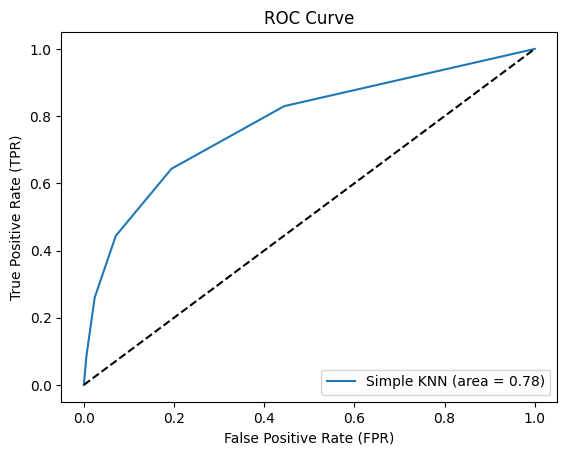

In [321]:
#roc curve of simplest models
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_true=y_val, y_score=knn.predict_proba(X_val_encoded)[:,1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.plot(fpr_knn, tpr_knn, label='Simple KNN (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

From these initial observations, we see two concerning trends: overfitting and class imbalance. 

I will attempt to address them through tuning various models. However, let's first try an artificial balancing of the target class.

# Try to balance the classes

Firstly, I will try random downsampling since the dataset is sufficiently large.

However, I would like to emphasize that in such cases, artificially balancing the classes is not an approach I find convincing. I believe that maintaining the statistical distribution in the training set is important, as we are dealing with customers who, despite having similar characteristics, may have different levels of risk.

In [322]:
class0_indexes = y_devtrain[y_devtrain==0].index
class1_indexes = y_devtrain[y_devtrain==1].index

class0_downsampled_indexes = np.random.choice(class0_indexes, size=len(class1_indexes), replace=False)

X_devtrain_dwn = pd.concat([X_devtrain.iloc[class0_downsampled_indexes], X_devtrain.iloc[class1_indexes]], axis=0)
y_devtrain_dwn = pd.concat([y_devtrain.iloc[class0_downsampled_indexes], y_devtrain.iloc[class1_indexes]], axis=0)

X_devtrain_dwn.reset_index(drop=True, inplace=True)
y_devtrain_dwn.reset_index(drop=True, inplace=True)

In [323]:
#check
num_default_balanced = (y_devtrain_dwn==1).sum()
num_nodefault_balanced = (y_devtrain_dwn==0).sum()

print("Amount of loans being default in balanced dataset: {} ({:.1f}%)".format(num_default_balanced, 100*num_default_balanced/len(y_devtrain_dwn)))
print("Amount of loans not being default in balanced dataset: {} ({:.1f}%)".format(num_nodefault_balanced, 100*num_nodefault_balanced/len(y_devtrain_dwn)))

Amount of loans being default in balanced dataset: 3039 (50.0%)
Amount of loans not being default in balanced dataset: 3039 (50.0%)


## Retry a simple KNN

In [324]:
#before applying a KNN, I have to transform categorical columns
X_devtrain_dwn_encoded = enconder.fit_transform(X_devtrain_dwn)

knn_dwn = KNeighborsClassifier()
knn_dwn.fit(X_devtrain_dwn_encoded, y_devtrain_dwn)
pred_y_val_encoded_dwn = knn_dwn.predict(X_val_encoded)
pred_y_devtrain_encoded_dwn = knn_dwn.predict(X_devtrain_dwn_encoded)

print("Classification report on train set:\n {}".format(classification_report(y_true=y_devtrain_dwn, y_pred=pred_y_devtrain_encoded_dwn)));
print("Classification report  on validation set:\n {}".format(classification_report(y_true=y_val, y_pred=pred_y_val_encoded_dwn)));

Classification report on train set:
               precision    recall  f1-score   support

           0       0.79      0.80      0.80      3039
           1       0.80      0.79      0.79      3039

    accuracy                           0.79      6078
   macro avg       0.80      0.79      0.79      6078
weighted avg       0.80      0.79      0.79      6078

Classification report  on validation set:
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      4720
           1       0.40      0.72      0.51      1292

    accuracy                           0.70      6012
   macro avg       0.65      0.71      0.65      6012
weighted avg       0.79      0.70      0.73      6012



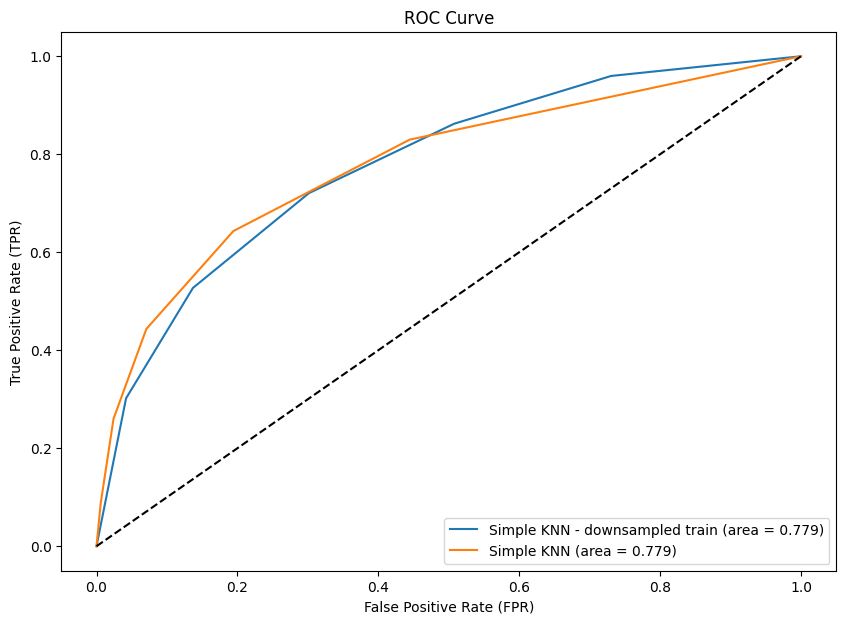

In [325]:
fpr_knn_dwn, tpr_knn_dwn, thresholds_knn_dwn = roc_curve(y_true=y_val, y_score=knn_dwn.predict_proba(X_val_encoded)[:,1])
roc_auc_knn_dwn = auc(fpr_knn_dwn, tpr_knn_dwn)

plt.figure(figsize=[10,7])
plt.plot(fpr_knn_dwn, tpr_knn_dwn, label='Simple KNN - downsampled train (area = %0.3f)' % roc_auc_knn_dwn)
plt.plot(fpr_knn, tpr_knn, label='Simple KNN (area = %0.3f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

It appears that downsampling does not lead to any improvement when the model is validated on real-world data (which is again imbalanced). As expected, a good recall is achieved, but the precision falls below 50%.

For now, I will abandon the dataset rebalancing approach in favor of models that are more equipped to handle class imbalance, such as decision trees.

# Pre-processing

The strategy I have decided to adopt is as follows:
- Scale the numerical features
- Perform encoding for categorical features
- In the case of ordinal encoding, apply scaling again

By doing this, all the features will have comparable values, and I can give KNN another chance.

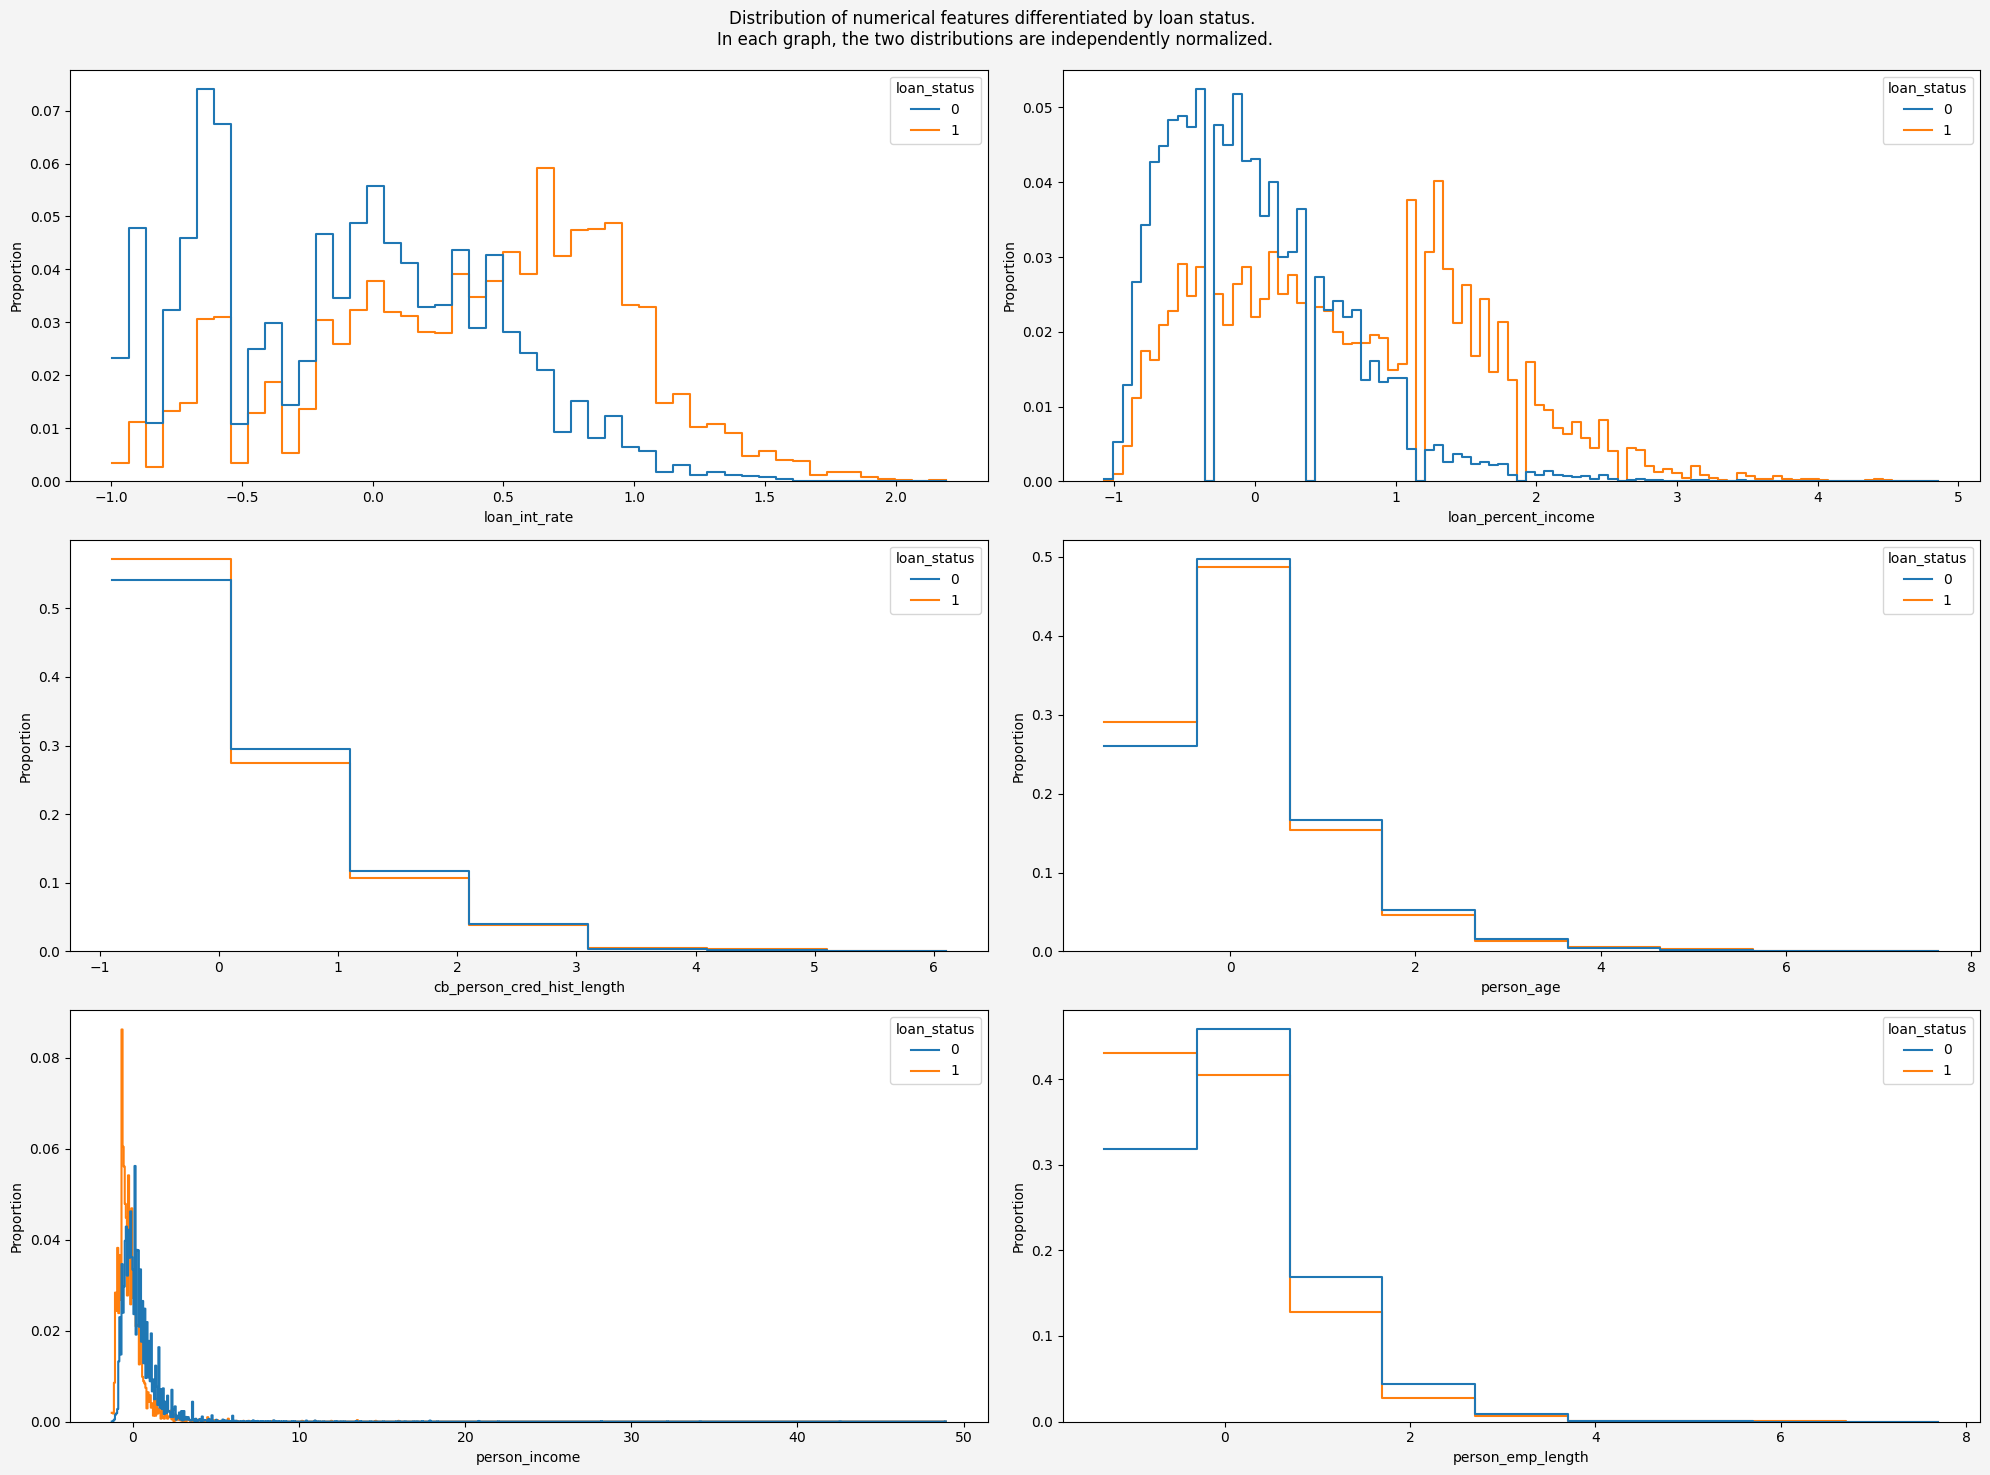

In [326]:
#let's take a first look to scaled numerical features
common_norm = False

df_scaled = df_cleaned.copy()
rs = RobustScaler()
for num_feature in numerical_features:
    df_scaled[num_feature] = rs.fit_transform(np.array(df_scaled[num_feature]).reshape(-1,1))

fig, axs = plt.subplots(3,2, figsize=[20,15])
fig.set_facecolor('#F4F4F4')

if common_norm:
    fig.suptitle("Distribution of numerical features differentiated by loan status.")
else:
    fig.suptitle("Distribution of numerical features differentiated by loan status. \nIn each graph, the two distributions are independently normalized.\n")

sns.histplot(data=df_scaled, x='loan_int_rate', hue='loan_status', stat='proportion', discrete=False, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[0,0])
sns.histplot(data=df_scaled, x='loan_percent_income', hue='loan_status', stat='proportion', discrete=False, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[0,1])
sns.histplot(data=df_scaled, x='cb_person_cred_hist_length', hue='loan_status', stat='proportion', discrete=True, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[1,0])
sns.histplot(data=df_scaled, x='person_age', hue='loan_status', stat='proportion', discrete=True, common_norm=False, multiple='layer', element='step', fill=False, ax=axs[1,1])
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
axs[2,0].xaxis.set_major_formatter(formatter)
sns.histplot(data=df_scaled, x='person_income', hue='loan_status', stat='proportion', discrete=False, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[2,0])
sns.histplot(data=df_scaled, x='person_emp_length', hue='loan_status', stat='proportion', discrete=True, common_norm=common_norm, multiple='layer', element='step', fill=False, ax=axs[2,1])

plt.tight_layout()
plt.show()

As expected from the very high absolute values, the customers' income still maintains significantly high maximum values even after scaling.

The choice of using the robust scaler is confirmed to be appropriate.

In [327]:
#make the full processor
ordinal_transformer = Pipeline(
    steps=[
        ('encoder', OrdinalEncoder()),
        ('scaler', StandardScaler())
    ]
)

full_processor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False), categorical_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('numerical', RobustScaler(), numerical_features)
    ]
)

In [328]:
#scale the devtrain and the validation dataset
X_devtrain_processed = full_processor.fit_transform(X_devtrain)
X_val_processed = full_processor.transform(X_val)

# Model selection

Since I am not aware of the specific goals of the potential client who may have commissioned this project, I cannot definitively determine whether to prioritize precision or recall in the model. 

However, given the class imbalance, accuracy is not the primary metric of interest. 

Considering these factors, I have decided to start evaluating different models, aiming to maximize the f1-score for class 1.

## KNN

#first look
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
knn.fit(X_devtrain_processed, y_devtrain)
pred_devtrain = knn.predict(X_devtrain_processed)
pred_val = knn.predict(X_val_processed)

print("Classification report on train set: \n{}".format(classification_report(y_true=y_devtrain, y_pred=pred_devtrain)))
print('Cross report on train set:')
cross_report(estimator=knn, X=X_devtrain_processed, y=y_devtrain)
print("Classification report on validation set: \n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))

#f1 scoring - unbalanced set - grid 1
#time: 3m
x = X_devtrain_processed
y = y_devtrain
grid = {
 'n_neighbors': range(3,32,2),
 'weights': ['uniform'],
 'p' : range(1,3)
 }

kfold = StratifiedKFold(n_splits=5, shuffle=True)
rs = GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1, param_grid=grid, scoring='f1', cv=kfold, verbose=1)
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/knn_gs_f1__unbalanced_set__tune1.joblib')

Best score: 0.789
Best params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


Cross report on train set:
	Accuracy:	0.8974
	F1-score:	0.7202
	Precision:	0.8809
	Recall:		0.6097
	ROC_AUC:	0.8639
Classification report on train set:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10987
           1       0.94      0.68      0.79      3039

    accuracy                           0.92     14026
   macro avg       0.93      0.83      0.87     14026
weighted avg       0.92      0.92      0.92     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      4720
           1       0.88      0.62      0.73      1292

    accuracy                           0.90      6012
   macro avg       0.89      0.80      0.83      6012
weighted avg       0.90      0.90      0.89      6012



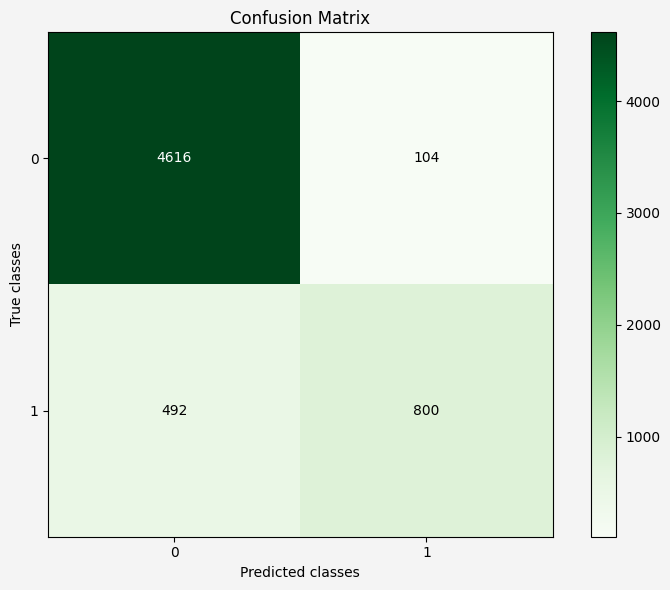

In [329]:
search_report(filename='dumped/knn_gs_f1__unbalanced_set__tune1.joblib', X_val=X_val_processed, y_val=y_val)

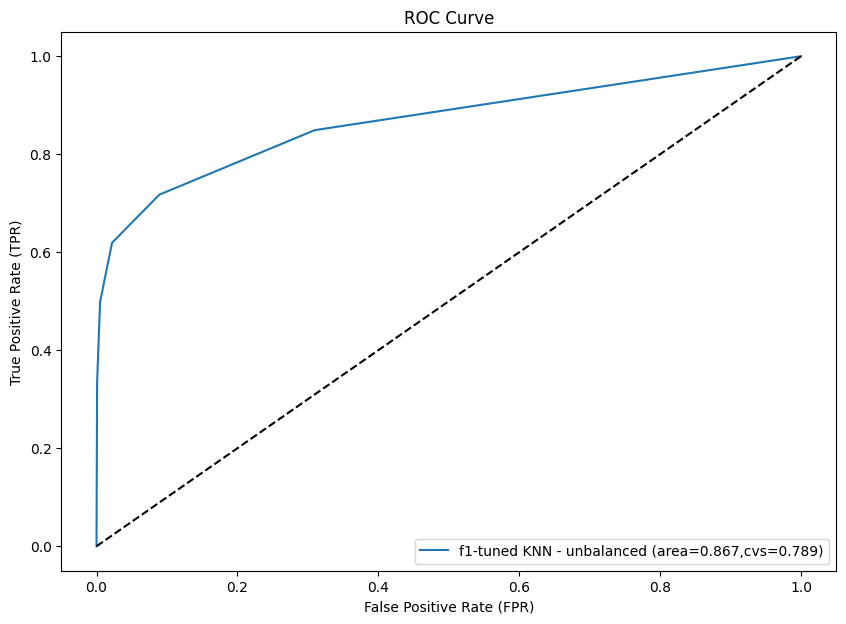

In [330]:
plt.figure(figsize=[10,7])

#knn f1-tuned unbalanced
plot_roc_from_tuned(filename='dumped/knn_gs_f1__unbalanced_set__tune1.joblib', label='f1-tuned KNN - unbalanced', X=X_val_processed, y=y_val)


plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The KNN model exhibits a slight overfitting, which I was unable to eliminate through tuning. 

However, with a precision of 0.88 and a recall of 0.62, it demonstrates a significant improvement compared to the initial attempts.

## Logistic Regression

#f1 scoring - unbalanced set - grid 1
#time: 8m
x = X_devtrain_processed
y = y_devtrain
grid = {
    'penalty' : ['elasticnet'],
    'C' : uniform(0,1),
    'l1_ratio': uniform(0,1),
    'max_iter': range(1,1000,50),
    'solver': ['saga'],
    'class_weight': ['balanced', None]
}

rs = RandomizedSearchCV(estimator=LogisticRegression(n_jobs=-1), n_jobs=-1, param_distributions=grid, n_iter=500, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/lr_gs_f1__unbalanced_set__tune1.joblib');

Best score: 0.613
Best params: {'C': 0.46752030145896883, 'class_weight': 'balanced', 'l1_ratio': 0.9636181129322815, 'max_iter': 351, 'penalty': 'elasticnet', 'solver': 'saga'}
Cross report on train set:
	Accuracy:	0.7853
	F1-score:	0.6132
	Precision:	0.5035
	Recall:		0.7848
	ROC_AUC:	0.8617
Classification report on train set:
               precision    recall  f1-score   support

           0       0.93      0.79      0.85     10987
           1       0.50      0.79      0.61      3039

    accuracy                           0.79     14026
   macro avg       0.72      0.79      0.73     14026
weighted avg       0.84      0.79      0.80     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86      4720
           1       0.52      0.79      0.63      1292

    accuracy                           0.80      6012
   macro avg       0.73      0.80      0.74      6012
weighted avg       0.84      0.80  

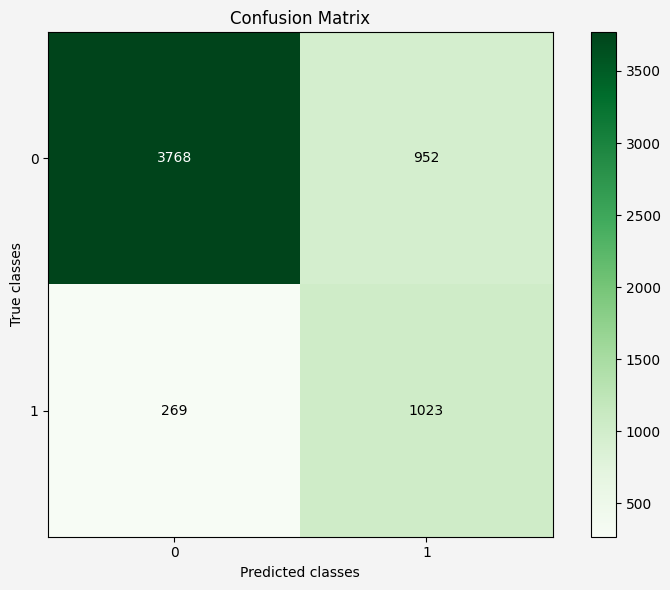

In [331]:
search_report(filename='dumped/lr_gs_f1__unbalanced_set__tune1.joblib', X_val=X_val_processed, y_val=y_val)

#f1 scoring - unbalanced set - grid 2
#time: 1m
x = X_devtrain_processed
y = y_devtrain
grid = {
    'C' : [0.01,0.1,1,10,100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'class_weight': ['balanced', None]
}

rs = GridSearchCV(estimator=LogisticRegression(n_jobs=-1), n_jobs=-1, param_grid=grid, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/lr_gs_f1__unbalanced_set__tune2.joblib');

Best score: 0.613
Best params: {'C': 1, 'class_weight': 'balanced', 'solver': 'sag'}
Cross report on train set:
	Accuracy:	0.7850
	F1-score:	0.6126
	Precision:	0.5030
	Recall:		0.7841
	ROC_AUC:	0.8616
Classification report on train set:
               precision    recall  f1-score   support

           0       0.93      0.78      0.85     10987
           1       0.50      0.79      0.61      3039

    accuracy                           0.79     14026
   macro avg       0.72      0.79      0.73     14026
weighted avg       0.84      0.79      0.80     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86      4720
           1       0.52      0.79      0.63      1292

    accuracy                           0.80      6012
   macro avg       0.73      0.80      0.74      6012
weighted avg       0.84      0.80      0.81      6012



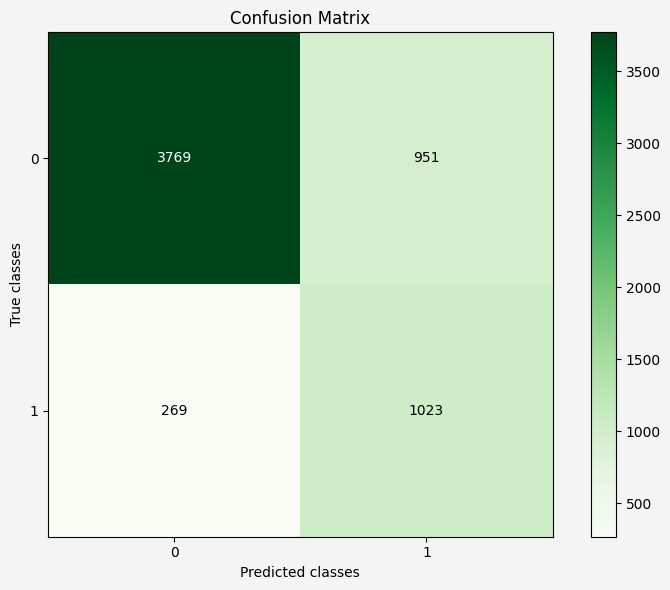

In [332]:
search_report(filename='dumped/lr_gs_f1__unbalanced_set__tune2.joblib', X_val=X_val_processed, y_val=y_val)

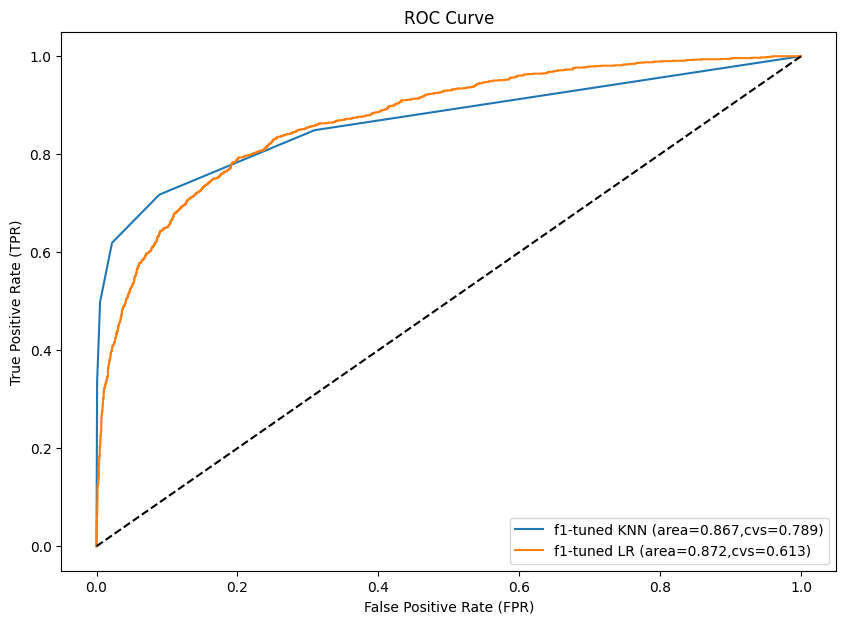

In [333]:
plt.figure(figsize=[10,7])

#f1-tuned KNN - unbalanced
plot_roc_from_tuned(filename='dumped/knn_gs_f1__unbalanced_set__tune1.joblib', label='f1-tuned KNN', X=X_val_processed, y=y_val)

#f1-tuned LR - unbalanced
plot_roc_from_tuned(filename='dumped/lr_gs_f1__unbalanced_set__tune2.joblib', label='f1-tuned LR', X=X_val_processed, y=y_val)


plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Despite tuning, the Logistic Regression model performs even worse than the KNN model in overall terms, but it achieves a significantly higher recall.

## DecisionTreeClassifier

#first look
dtc = DecisionTreeClassifier()
dtc.fit(X_devtrain_processed, y_devtrain)
pred_devtrain = dtc.predict(X_devtrain_processed)
pred_val = dtc.predict(X_val_processed)

print("Classification report of a default DecisionTreeClassifier - train set: \n{}".format(classification_report(y_true=y_devtrain, y_pred=pred_devtrain)))
print("Classification report of a default DecisionTreeClassifier - validation set: \n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))

print("Cross validation score on train set: {}".format(cross_val_score(dtc, X=X_devtrain_processed, y=y_devtrain).mean()))
print("Cross validation score on test set: {}".format(cross_val_score(dtc, X=X_val_processed, y=y_val).mean()))

Good scores, but very high overfitting.

#first naive tuning
dtc = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_impurity_decrease=0.001, min_samples_leaf=5, min_weight_fraction_leaf=0.001, max_features=0.9)
dtc.fit(X_devtrain_processed, y_devtrain)
pred_devtrain = dtc.predict(X_devtrain_processed)
pred_val = dtc.predict(X_val_processed)

print("Classification report of a balanced DecisionTreeClassifier - train set: \n{}".format(classification_report(y_true=y_devtrain, y_pred=pred_devtrain)))
print("Classification report of a balanced DecisionTreeClassifier - validation set: \n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))

print("Cross validation score on train set: {}".format(cross_val_score(dtc, X=X_devtrain_processed, y=y_devtrain).mean()))
print("Cross validation score on test set: {}".format(cross_val_score(dtc, X=X_val_processed, y=y_val).mean()))

Much better, but it can be fine tuned.

#f1-scoring - unbalanced set - grid 1
#time: 9m
x = X_devtrain_processed
y = y_devtrain
grid = {
    'class_weight' : ['balanced'],
    'criterion' : ["gini", "entropy"],
    'max_depth': [1,3,10,15],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005],
    'min_weight_fraction_leaf': [0, 0.0005, 0.001, 0.005],
    'min_samples_leaf': [2, 3, 5, 7, 10],
    'max_features' : [0.85,0.9,0.95,1.0]
}

rs = GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1, param_grid=grid, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/dtc_gs_f1__unbalanced_set__tune1.joblib');

Best score: 0.812
Best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.95, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0}
Cross report on train set:
	Accuracy:	0.9214
	F1-score:	0.8045
	Precision:	0.8809
	Recall:		0.7420
	ROC_AUC:	0.9168
Classification report on train set:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96     10987
           1       0.93      0.74      0.82      3039

    accuracy                           0.93     14026
   macro avg       0.93      0.86      0.89     14026
weighted avg       0.93      0.93      0.93     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      4720
           1       0.91      0.72      0.81      1292

    accuracy                           0.93      6012
   macro avg       0.92      0.85      0.88      6012
weig

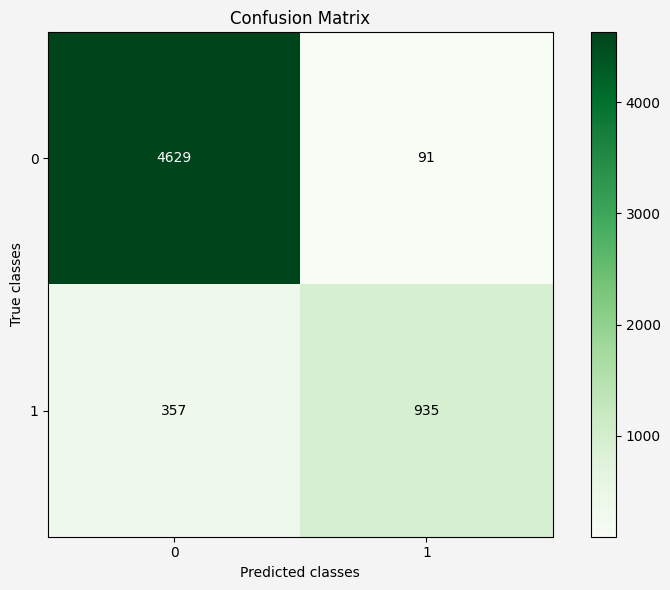

In [334]:
search_report(filename='dumped/dtc_gs_f1__unbalanced_set__tune1.joblib', X_val=X_val_processed, y_val=y_val)

#f1-scoring - unbalanced set - grid 2
#time: 9m
x = X_devtrain_processed
y = y_devtrain
grid = {
    'class_weight' : ['balanced'],
    'criterion' : ["gini", "entropy"],
    'max_depth': [10,15,20],
    'min_impurity_decrease': [0.0008, 0.001, 0.0015],
    'min_weight_fraction_leaf': [0, 0.0005, 0.001],
    'min_samples_leaf': [2, 3, 4, 5],
    'max_features' : [0.92,0.95,0.97,1.0]
}

rs = GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1, param_grid=grid, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/dtc_gs_f1__unbalanced_set__tune2.joblib');

Best score: 0.814
Best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.97, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0}
Cross report on train set:
	Accuracy:	0.9241
	F1-score:	0.8087
	Precision:	0.8931
	Recall:		0.7394
	ROC_AUC:	0.9176
Classification report on train set:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     10987
           1       0.90      0.74      0.81      3039

    accuracy                           0.93     14026
   macro avg       0.91      0.86      0.88     14026
weighted avg       0.92      0.93      0.92     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      4720
           1       0.88      0.73      0.80      1292

    accuracy                           0.92      6012
   macro avg       0.90      0.85      0.87      6012
weig

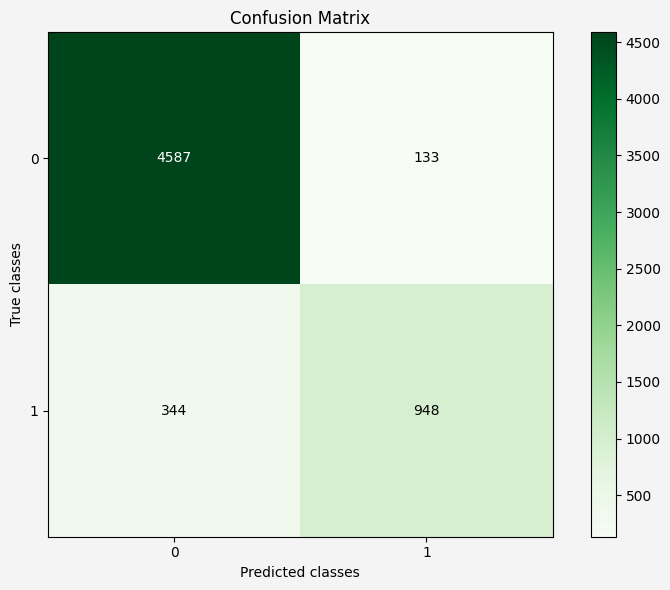

In [335]:
search_report(filename='dumped/dtc_gs_f1__unbalanced_set__tune2.joblib', X_val=X_val_processed, y_val=y_val)

#f1-scoring - unbalanced set - grid 3
#time: 9m
x = X_devtrain_processed
y = y_devtrain
grid = {
    'class_weight' : ['balanced'],
    'criterion' : ["gini", "entropy"],
    'max_depth': [8,9,10,11,12],
    'min_impurity_decrease': [0.0009, 0.001, 0.0012],
    'min_weight_fraction_leaf': [0],
    'min_samples_leaf': [4],
    'max_features' : [0.96,0.97,0.98]
}

rs = GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1, param_grid=grid, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/dtc_gs_f1__unbalanced_set__tune3.joblib');

Best score: 0.813
Best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12, 'max_features': 0.96, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0}
Cross report on train set:
	Accuracy:	0.9273
	F1-score:	0.8144
	Precision:	0.9118
	Recall:		0.7364
	ROC_AUC:	0.9190
Classification report on train set:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     10987
           1       0.89      0.75      0.81      3039

    accuracy                           0.93     14026
   macro avg       0.91      0.86      0.88     14026
weighted avg       0.92      0.93      0.92     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      4720
           1       0.87      0.73      0.80      1292

    accuracy                           0.92      6012
   macro avg       0.90      0.85      0.87      6012
weig

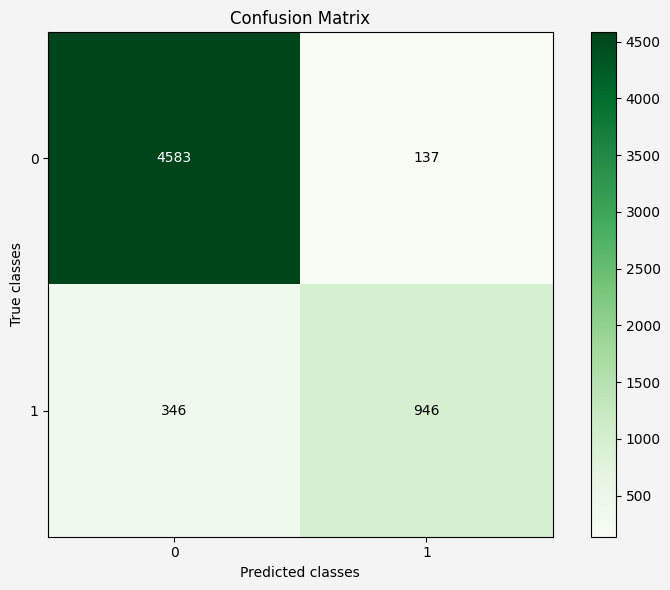

In [336]:
search_report(filename='dumped/dtc_gs_f1__unbalanced_set__tune3.joblib', X_val=X_val_processed, y_val=y_val)

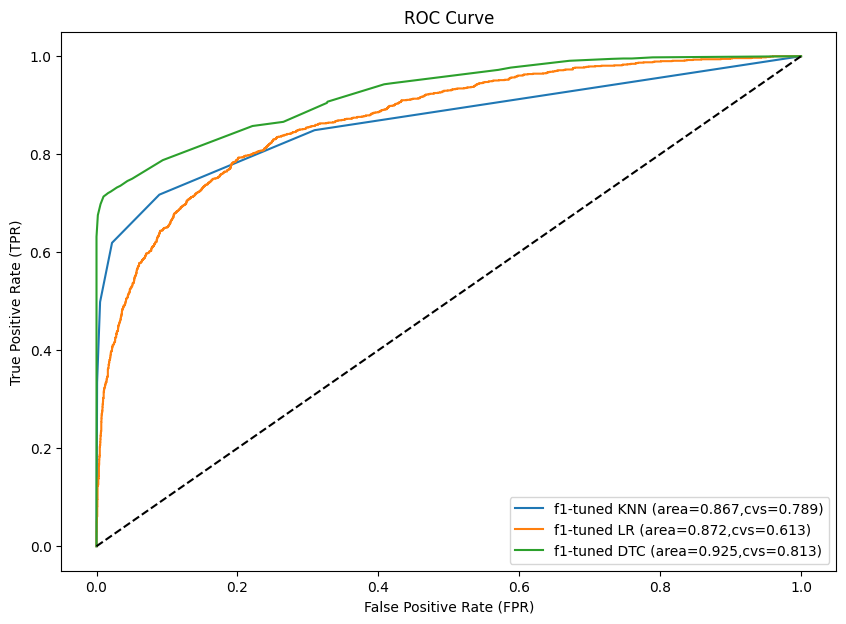

In [337]:
plt.figure(figsize=[10,7])

#f1-tuned KNN
plot_roc_from_tuned(filename='dumped/knn_gs_f1__unbalanced_set__tune1.joblib', label='f1-tuned KNN', X=X_val_processed, y=y_val)

#f1-tuned LR
plot_roc_from_tuned(filename='dumped/lr_gs_f1__unbalanced_set__tune2.joblib', label='f1-tuned LR', X=X_val_processed, y=y_val)

#f1-tuned DTC
plot_roc_from_tuned(filename='dumped/dtc_gs_f1__unbalanced_set__tune3.joblib', label='f1-tuned DTC', X=X_val_processed, y=y_val)


plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The Decision Tree model represents a significant improvement, achieving an f1-score of approximately 0.80, and it also resolves the initial overfitting issue after fine-tuning.

## Random Forest

#first look
rfc = RandomForestClassifier()
rfc.fit(X_devtrain_processed, y_devtrain)
pred_devtrain = rfc.predict(X_devtrain_processed)
pred_val = rfc.predict(X_val_processed)

print("Classification report of a default DecisionTreeClassifier - train set: \n{}".format(classification_report(y_true=y_devtrain, y_pred=pred_devtrain)))
print("Classification report of a default DecisionTreeClassifier - validation set: \n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))

print("Cross validation score on train set: {}".format(cross_val_score(rfc, X=X_devtrain_processed, y=y_devtrain, scoring='f1').mean()))
print("Cross validation score on test set: {}".format(cross_val_score(rfc, X=X_val_processed, y=y_val, scoring='f1').mean()))

Very good results, but high overfitting again.

#first naive tuning
#Best params of a single Tree: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12, 'max_features': 0.96, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0}
rfc = RandomForestClassifier(n_estimators=150, class_weight='balanced', criterion="entropy", max_depth=12, max_features=0.9, min_impurity_decrease=0.001, min_samples_leaf=3)
rfc.fit(X_devtrain_processed, y_devtrain)
pred_devtrain = rfc.predict(X_devtrain_processed)
pred_val = rfc.predict(X_val_processed)

print("Classification report of a naively tuned RandomForestClassifier - train set: \n{}".format(classification_report(y_true=y_devtrain, y_pred=pred_devtrain)))
print("Classification report of a naively tuned RandomForestClassifier - validation set: \n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))

#f1-scoring - unbalanced set - grid 1
#force a minimum impurity decrease to control overfitting
#force balanced to enhance recall
#time: 2m
x = X_devtrain_processed
y = y_devtrain
grid = {
    'class_weight' : ['balanced'],
    'criterion' : ["entropy"],
    'max_depth': [1,3,10],
    'min_impurity_decrease': [0.001, 0.01, 0.1],
    'min_samples_leaf': [2, 10, 20],
    'max_features' : ['sqrt','log2',0.9,1],
    'n_estimators' : [50,100,150]
}

rs = GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1, param_grid=grid, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/rfc_gs_f1__unbalanced_set__tune1.joblib');

Best score: 0.820
Best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.9, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2, 'n_estimators': 50}
Cross report on train set:
	Accuracy:	0.9288
	F1-score:	0.8170
	Precision:	0.9209
	Recall:		0.7344
	ROC_AUC:	0.9294
Classification report on train set:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     10987
           1       0.94      0.75      0.84      3039

    accuracy                           0.94     14026
   macro avg       0.94      0.87      0.90     14026
weighted avg       0.94      0.94      0.93     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      4720
           1       0.92      0.73      0.82      1292

    accuracy                           0.93      6012
   macro avg       0.93      0.86      0.89      6012
weighted avg    

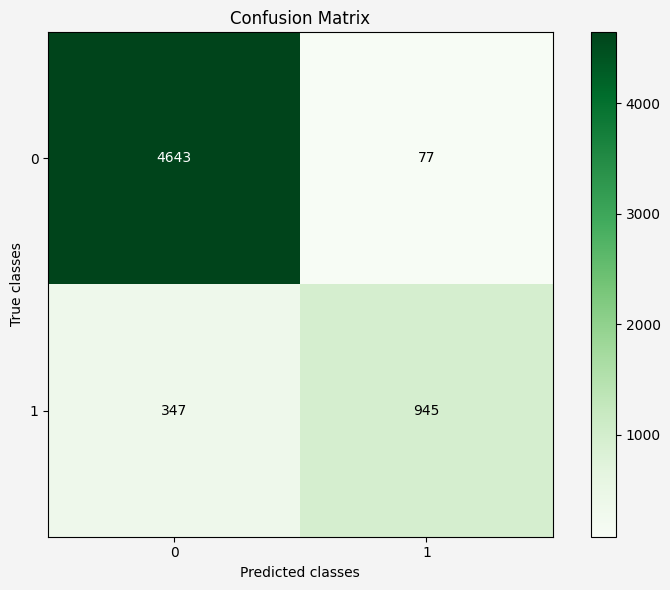

In [338]:
search_report(filename='dumped/rfc_gs_f1__unbalanced_set__tune1.joblib', X_val=X_val_processed, y_val=y_val)

#f1-scoring - unbalanced set - grid 2
#force a minimum impurity decrease to control overfitting
#force balanced to enhance recall
#time: 40s
x = X_devtrain_processed
y = y_devtrain
grid = {
    'class_weight' : ['balanced'],
    'criterion' : ["entropy"],
    'max_depth': [8,10,12],
    'min_impurity_decrease': [0.001],
    'min_samples_leaf': [2,3,4],
    'max_features' : [0.8,0.9,1],
    'n_estimators' : [30,50,100]
}

rs = GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1, param_grid=grid, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/rfc_gs_f1__unbalanced_set__tune2.joblib');

Best score: 0.821
Best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12, 'max_features': 0.9, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 3, 'n_estimators': 50}
Cross report on train set:
	Accuracy:	0.9281
	F1-score:	0.8157
	Precision:	0.9161
	Recall:		0.7354
	ROC_AUC:	0.9302
Classification report on train set:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     10987
           1       0.94      0.75      0.83      3039

    accuracy                           0.94     14026
   macro avg       0.94      0.87      0.90     14026
weighted avg       0.94      0.94      0.93     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      4720
           1       0.92      0.73      0.82      1292

    accuracy                           0.93      6012
   macro avg       0.93      0.86      0.89      6012
weighted avg    

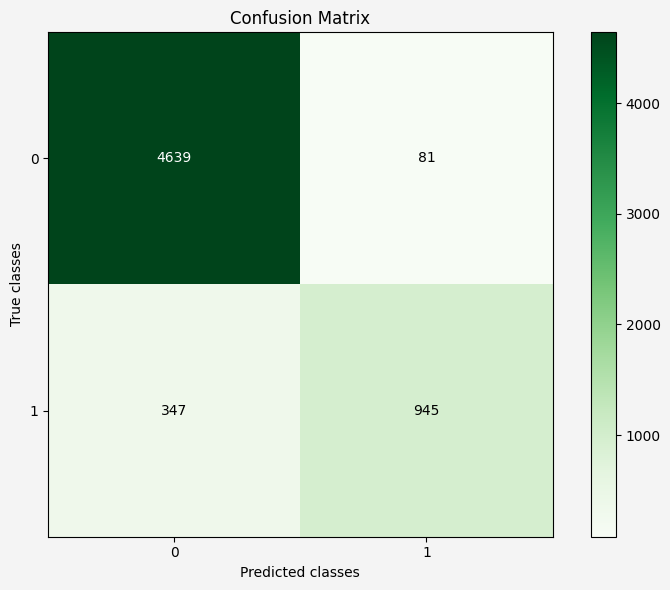

In [339]:
search_report(filename='dumped/rfc_gs_f1__unbalanced_set__tune2.joblib', X_val=X_val_processed, y_val=y_val)

#f1-scoring - unbalanced set - grid 3
#force a minimum impurity decrease to control overfitting
#force balanced to enhance recall
#time: 9m
x = X_devtrain_processed
y = y_devtrain
grid = {
    'class_weight' : ['balanced'],
    'criterion' : ["entropy"],
    'max_depth': [11,12,13],
    'min_impurity_decrease': [0.001],
    'min_samples_leaf': [3],
    'max_features' : [0.85,0.9,0.95],
    'n_estimators' : [40,50,70,80]
}

rs = GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1, param_grid=grid, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/rfc_gs_f1__unbalanced_set__tune3.joblib');

Best score: 0.820
Best params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 13, 'max_features': 0.95, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 3, 'n_estimators': 80}
Cross report on train set:
	Accuracy:	0.9287
	F1-score:	0.8165
	Precision:	0.9219
	Recall:		0.7331
	ROC_AUC:	0.9298
Classification report on train set:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     10987
           1       0.94      0.75      0.84      3039

    accuracy                           0.94     14026
   macro avg       0.94      0.87      0.90     14026
weighted avg       0.94      0.94      0.93     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      4720
           1       0.92      0.73      0.82      1292

    accuracy                           0.93      6012
   macro avg       0.93      0.86      0.89      6012
weighted avg   

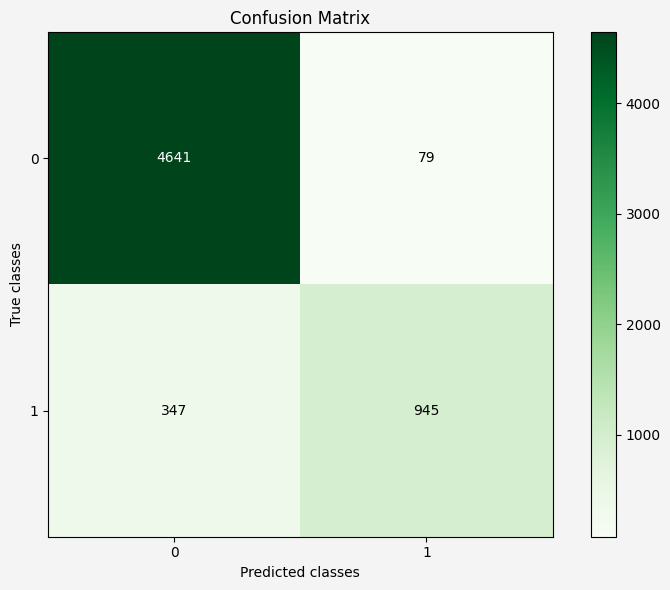

In [340]:
search_report(filename='dumped/rfc_gs_f1__unbalanced_set__tune3.joblib', X_val=X_val_processed, y_val=y_val)

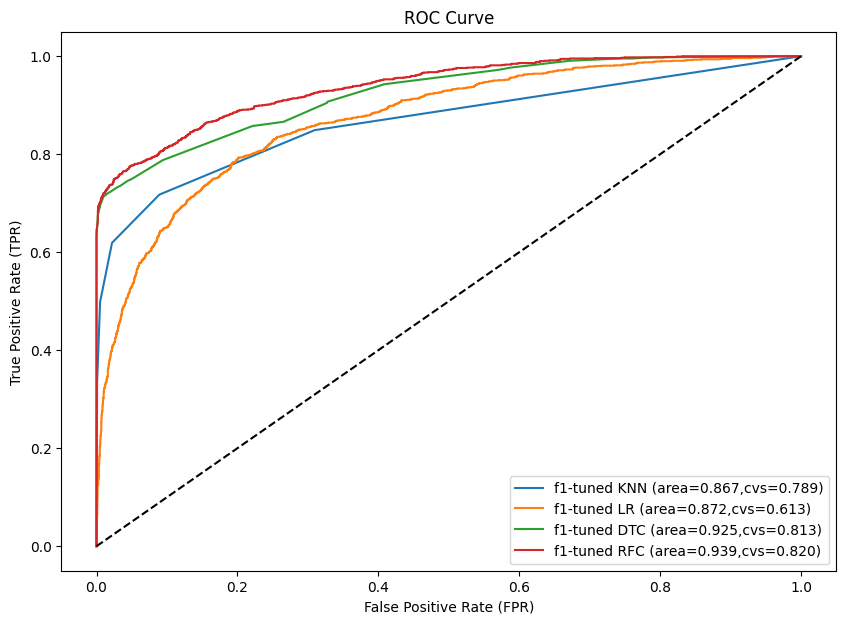

In [341]:
plt.figure(figsize=[10,7])

#f1-tuned KNN
plot_roc_from_tuned(filename='dumped/knn_gs_f1__unbalanced_set__tune1.joblib', label='f1-tuned KNN', X=X_val_processed, y=y_val)

#f1-tuned LR
plot_roc_from_tuned(filename='dumped/lr_gs_f1__unbalanced_set__tune2.joblib', label='f1-tuned LR', X=X_val_processed, y=y_val)

#f1-tuned DTC
plot_roc_from_tuned(filename='dumped/dtc_gs_f1__unbalanced_set__tune3.joblib', label='f1-tuned DTC', X=X_val_processed, y=y_val)

#f1-tuned RFC
plot_roc_from_tuned(filename='dumped/rfc_gs_f1__unbalanced_set__tune3.joblib', label='f1-tuned RFC', X=X_val_processed, y=y_val)


plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The Random Forest model further improves the results. Unfortunately, it seems that the recall does not increase significantly.

## XGBoost

#first look

xbc = xgb.XGBClassifier()
xbc.fit(X_devtrain_processed, y_devtrain)
pred_devtrain = xbc.predict(X_devtrain_processed)
pred_val = xbc.predict(X_val_processed)

print("Classification report of a default DecisionTreeClassifier - train set: \n{}".format(classification_report(y_true=y_devtrain, y_pred=pred_devtrain)))
print("Classification report of a default DecisionTreeClassifier - validation set: \n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))

#naive tuning

xbc = xgb.XGBClassifier(objective="binary:logistic", 
                        max_depth=6, 
                        n_estimators=100,
                        colsample_bytree=0.8,
                        learning_rate=0.1,
                        subsample=0.6)
xbc.fit(X_devtrain_processed, y_devtrain)
pred_devtrain = xbc.predict(X_devtrain_processed)
pred_val = xbc.predict(X_val_processed)

print("Classification report of a default DecisionTreeClassifier - train set: \n{}".format(classification_report(y_true=y_devtrain, y_pred=pred_devtrain)))
print("Classification report of a default DecisionTreeClassifier - validation set: \n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))

#f1-scoring - unbalanced set - grid 1
#time: 2h
x = X_devtrain_processed
y = y_devtrain
grid = {
    'max_depth': [3,6,10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01,0.1,0.3,0.5],
    'colsample_bytree': [0.5,0.7,1],
    'subsample': [0.6,0.8,1],
    'gamma': [0,1,5],
    'reg_lambda': [0,1,5],
    'reg_alpha': [0,1,5]
}

rs = GridSearchCV(estimator=xgb.XGBClassifier(n_jobs=-1), n_jobs=-1, param_grid=grid, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/xgb_gs_f1__unbalanced_set__tune1.joblib');

Best score: 0.837
Best params: {'colsample_bytree': 0.7, 'gamma': 5, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 1}
Cross report on train set:
	Accuracy:	0.9380
	F1-score:	0.8367
	Precision:	0.9746
	Recall:		0.7331
	ROC_AUC:	0.9411
Classification report on train set:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     10987
           1       0.99      0.76      0.86      3039

    accuracy                           0.95     14026
   macro avg       0.96      0.88      0.91     14026
weighted avg       0.95      0.95      0.94     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      4720
           1       0.97      0.73      0.83      1292

    accuracy                           0.94      6012
   macro avg       0.95      0.86      0.90      6012
weighted avg       0.94      0.94   

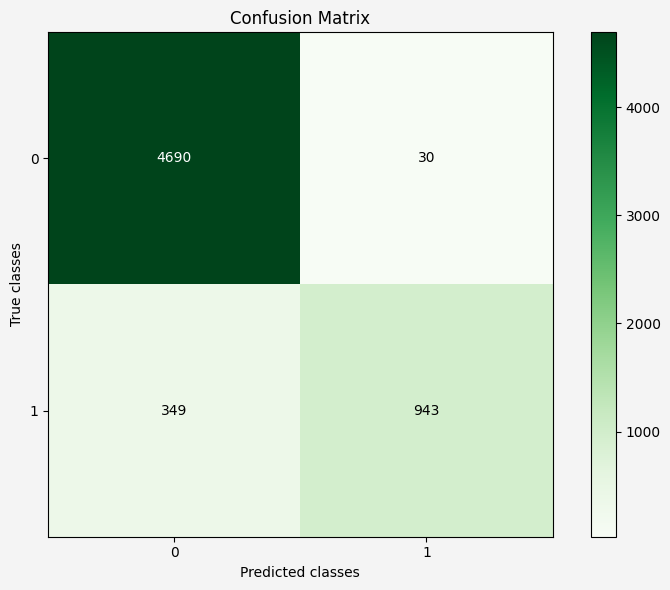

In [342]:
search_report(filename='dumped/xgb_gs_f1__unbalanced_set__tune1.joblib', X_val=X_val_processed, y_val=y_val)

#f1-scoring - unbalanced set - grid 2
#time: 2h
x = X_devtrain_processed
y = y_devtrain
grid = {
    'max_depth': [6,9,12],
    'n_estimators': [20, 50, 80],
    'learning_rate': [0.2,0.3,0.4],
    'colsample_bytree': [0.6,0.7,0.8],
    'subsample': [0.9,1],
    'gamma': [3,5],
    'reg_lambda': [0,1],
    'reg_alpha': [1,3]
}

rs = GridSearchCV(estimator=xgb.XGBClassifier(n_jobs=-1), n_jobs=-1, param_grid=grid, scoring='f1')
rs.fit(x, y)

dumping = {
    'model':rs,
    'x':x,
    'y':y
}
dump(dumping, 'dumped/xgb_gs_f1__unbalanced_set__tune2.joblib');

Best score: 0.837
Best params: {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.4, 'max_depth': 9, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1}
Cross report on train set:
	Accuracy:	0.9382
	F1-score:	0.8371
	Precision:	0.9743
	Recall:		0.7341
	ROC_AUC:	0.9390
Classification report on train set:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     10987
           1       0.98      0.76      0.85      3039

    accuracy                           0.94     14026
   macro avg       0.96      0.88      0.91     14026
weighted avg       0.95      0.94      0.94     14026

Classification report on val set:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      4720
           1       0.97      0.73      0.83      1292

    accuracy                           0.94      6012
   macro avg       0.95      0.86      0.90      6012
weighted avg       0.94      0.94    

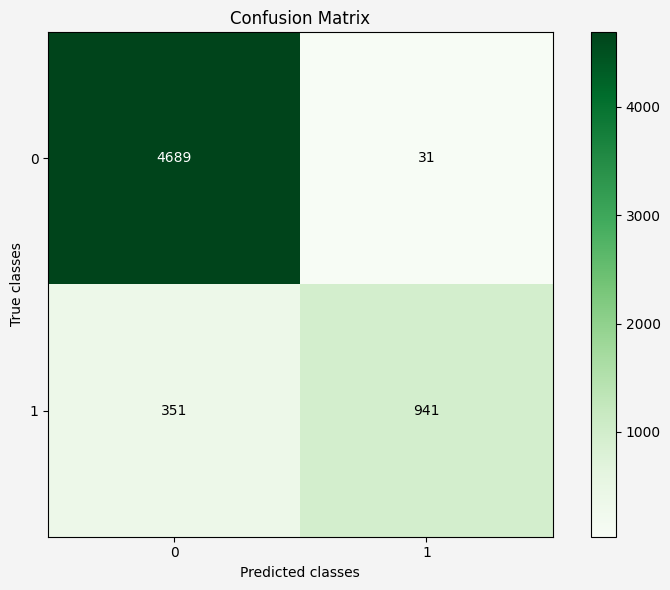

In [343]:
search_report(filename='dumped/xgb_gs_f1__unbalanced_set__tune2.joblib', X_val=X_val_processed, y_val=y_val)

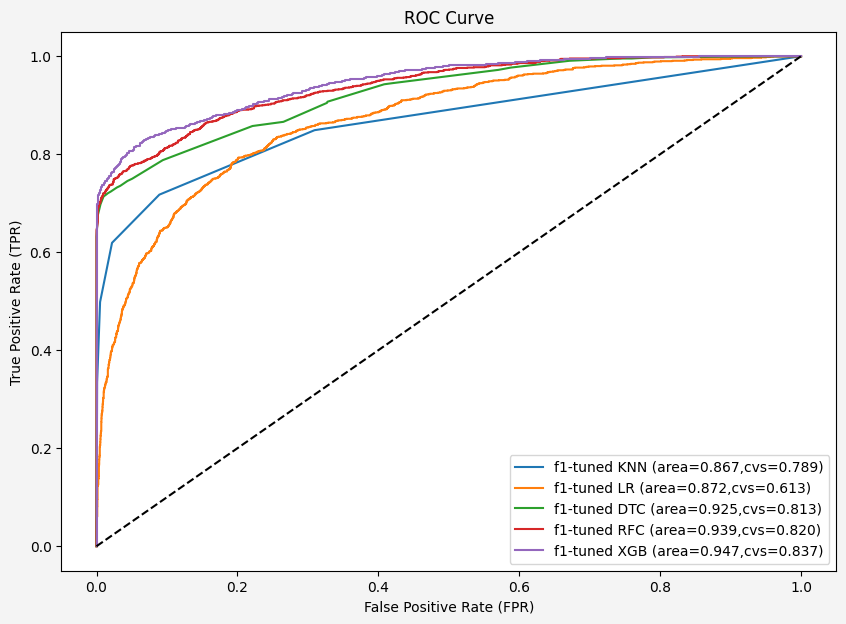

In [344]:
plt.figure(figsize=[10,7],  facecolor='#F4F4F4')

#f1-tuned KNN
plot_roc_from_tuned(filename='dumped/knn_gs_f1__unbalanced_set__tune1.joblib', label='f1-tuned KNN', X=X_val_processed, y=y_val)

#f1-tuned LR
plot_roc_from_tuned(filename='dumped/lr_gs_f1__unbalanced_set__tune2.joblib', label='f1-tuned LR', X=X_val_processed, y=y_val)

#f1-tuned DTC
plot_roc_from_tuned(filename='dumped/dtc_gs_f1__unbalanced_set__tune3.joblib', label='f1-tuned DTC', X=X_val_processed, y=y_val)

#f1-tuned RFC
plot_roc_from_tuned(filename='dumped/rfc_gs_f1__unbalanced_set__tune3.joblib', label='f1-tuned RFC', X=X_val_processed, y=y_val)

#f1-tuned XGB
plot_roc_from_tuned(filename='dumped/xgb_gs_f1__unbalanced_set__tune2.joblib', label='f1-tuned XGB', X=X_val_processed, y=y_val)


plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The XGBoost (Extreme Gradient Boosting) model represents another significant step forward, achieving notably high precision.

## Voting Classifier

After trying out various models and obtaining good results, particularly with Random Forest and XGBoost, I would like to attempt to improve the recall by using a Voting Classifier model aimed at maximizing recall.

In [345]:
def prepare_voting_classifier(estimators: list[BaseEstimator], estimators_labels: list[str], weigth_score: Callable[[np.ndarray, np.ndarray], float], x: np.ndarray, y_true: np.ndarray):
    estimators_output = [(label, estimator) for label, estimator in zip(estimators_labels, estimators)]
    weigths_output = [weigth_score(y_true, estimator.predict(x)) for estimator in estimators]
    return estimators_output, weigths_output   

I would like to try different ensemble combinations in order to maximize the recall of the final model.

In [346]:
#load the models
#include logistic regression, because it still has the best recall
lr = load('dumped/lr_gs_f1__unbalanced_set__tune2.joblib')['model'].best_estimator_
rfc = load('dumped/rfc_gs_f1__unbalanced_set__tune3.joblib')['model'].best_estimator_
dtc = load('dumped/dtc_gs_f1__unbalanced_set__tune3.joblib')['model'].best_estimator_
xbc = load('dumped/xgb_gs_f1__unbalanced_set__tune1.joblib')['model'].best_estimator_

#second list with the three best models
estimator_list = [rfc, dtc, xbc]
labels = ['rfc', 'dtc', 'xbc']
#make weights based on recall scores
estimators, weigths = prepare_voting_classifier(estimators=estimator_list, estimators_labels=labels, x=X_val_processed, y_true=y_val, weigth_score=recall_score)

#second list including logistic regression
estimator_list_with_lr = [lr, rfc, dtc, xbc]
labels_with_lr = ['lr', 'rfc', 'dtc', 'xbc']
estimators_with_lr, weigths_with_lr = prepare_voting_classifier(estimators=estimator_list_with_lr, estimators_labels=labels_with_lr, x=X_val_processed, y_true=y_val, weigth_score=recall_score)

#third list also the best model overall (xgb) and the logistic regression
estimator_list_restricted = [lr, xbc]
labels_restricted = ['lr', 'xbc']
estimators_restricted, weigths_restricted = prepare_voting_classifier(estimators=estimator_list_restricted, estimators_labels=labels_restricted, x=X_val_processed, y_true=y_val, weigth_score=recall_score)

vcs = VotingClassifier(n_jobs=-1, voting='soft', weights=weigths, estimators=estimators)
vcs.fit(X_devtrain_processed, y_devtrain)

dumping = {
    'model':vcs,
    'x':X_devtrain_processed,
    'y':y_devtrain
}
dump(dumping, 'dumped/vc_soft__unbalanced_set_1.joblib');

vcs_lr = VotingClassifier(n_jobs=-1, voting='soft', weights=weigths_with_lr, estimators=estimators_with_lr)
vcs_lr.fit(X_devtrain_processed, y_devtrain)

dumping = {
    'model':vcs_lr,
    'x':X_devtrain_processed,
    'y':y_devtrain
}
dump(dumping, 'dumped/vc_soft_lr__unbalanced_set_1.joblib');

Classification report on devtrain set:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10987
           1       0.96      0.75      0.84      3039

    accuracy                           0.94     14026
   macro avg       0.95      0.87      0.90     14026
weighted avg       0.94      0.94      0.94     14026

Classification report on val set:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4720
           1       0.94      0.73      0.83      1292

    accuracy                           0.93      6012
   macro avg       0.94      0.86      0.89      6012
weighted avg       0.93      0.93      0.93      6012



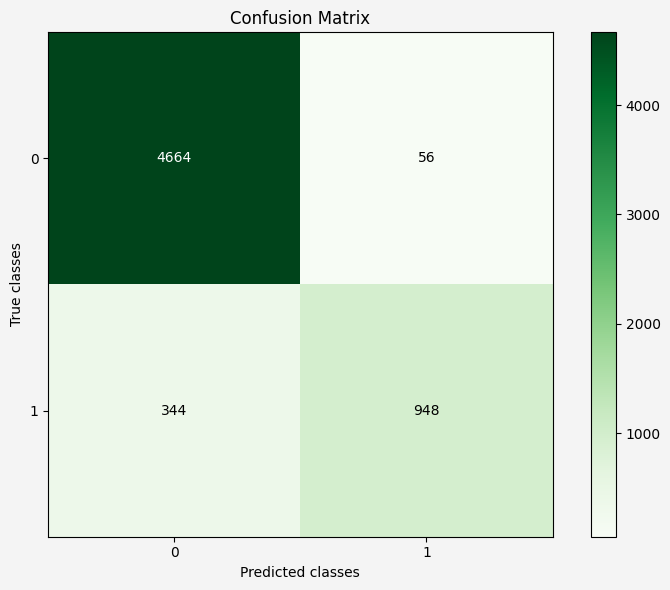

In [347]:
#first list: Voting Classifier Soft of the three best models
loaded = load('dumped/vc_soft__unbalanced_set_1.joblib')
model = loaded['model']
x = loaded['x']
y = loaded['y']
pred_val = model.predict(X_val_processed)
pred_devtrain = model.predict(x)
print("Classification report on devtrain set:\n{}".format(classification_report(y_true=y, y_pred=pred_devtrain)))
print("Classification report on val set:\n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))
plot_confusion_matrix(y_true=y_val, y_pred=pred_val)

Classification report on devtrain set:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10987
           1       0.93      0.77      0.84      3039

    accuracy                           0.94     14026
   macro avg       0.94      0.88      0.90     14026
weighted avg       0.94      0.94      0.93     14026

Classification report on val set:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      4720
           1       0.91      0.75      0.82      1292

    accuracy                           0.93      6012
   macro avg       0.92      0.86      0.89      6012
weighted avg       0.93      0.93      0.93      6012



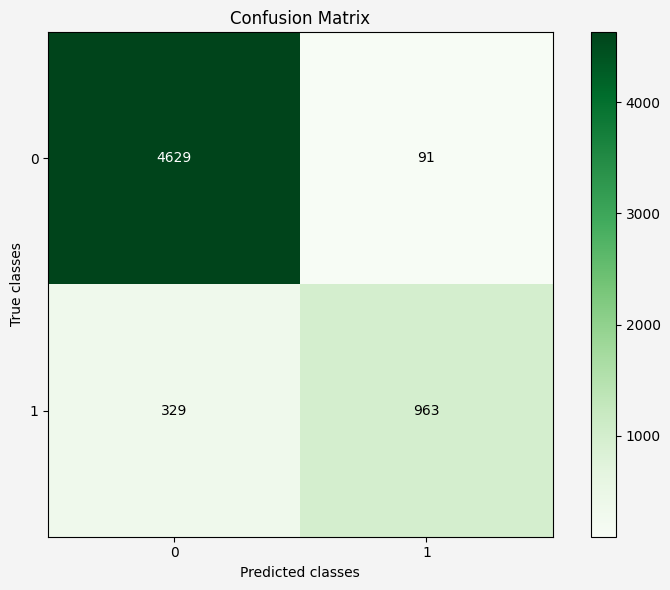

In [348]:
#second list including logistic regression
loaded = load('dumped/vc_soft_lr__unbalanced_set_1.joblib')
model = loaded['model']
x = loaded['x']
y = loaded['y']
pred_val = model.predict(X_val_processed)
pred_devtrain = model.predict(x)
print("Classification report on devtrain set:\n{}".format(classification_report(y_true=y, y_pred=pred_devtrain)))
print("Classification report on val set:\n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))
plot_confusion_matrix(y_true=y_val, y_pred=pred_val)

vcs_restricted = VotingClassifier(n_jobs=-1, voting='soft', weights=weigths_restricted, estimators=estimators_restricted)
vcs_restricted.fit(X_devtrain_processed, y_devtrain)

dumping = {
    'model':vcs_restricted,
    'x':X_devtrain_processed,
    'y':y_devtrain
}
dump(dumping, 'dumped/vc_soft_red__unbalanced_set_1.joblib');

Classification report on devtrain set:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10987
           1       0.87      0.78      0.82      3039

    accuracy                           0.93     14026
   macro avg       0.90      0.88      0.89     14026
weighted avg       0.93      0.93      0.93     14026



Cross validation score on devtrain set: 0.7946461916046615
Classification report on val set:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4720
           1       0.85      0.76      0.81      1292

    accuracy                           0.92      6012
   macro avg       0.90      0.86      0.88      6012
weighted avg       0.92      0.92      0.92      6012

Cross validation score on val set: 0.7715528636210098


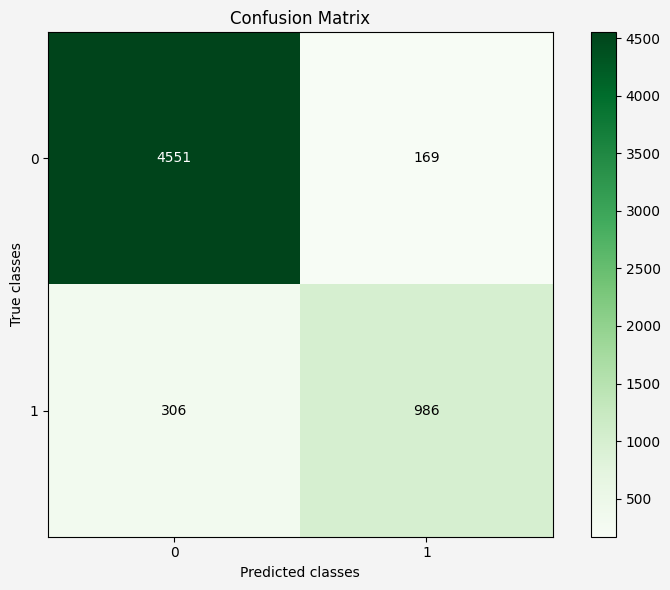

In [349]:
loaded = load('dumped/vc_soft_red__unbalanced_set_1.joblib')
model = loaded['model']
x = loaded['x']
y = loaded['y']
pred_val = model.predict(X_val_processed)
pred_devtrain = model.predict(x)
print("Classification report on devtrain set:\n{}".format(classification_report(y_true=y, y_pred=pred_devtrain)))
print("Cross validation score on devtrain set: {}".format(cross_val_score(estimator=model, X=x, y=y, scoring='f1').mean()))
print("Classification report on val set:\n{}".format(classification_report(y_true=y_val, y_pred=pred_val)))
print("Cross validation score on val set: {}".format(cross_val_score(estimator=model, X=X_val_processed, y=y_val, scoring='f1').mean()))
plot_confusion_matrix(y_true=y_val, y_pred=pred_val)

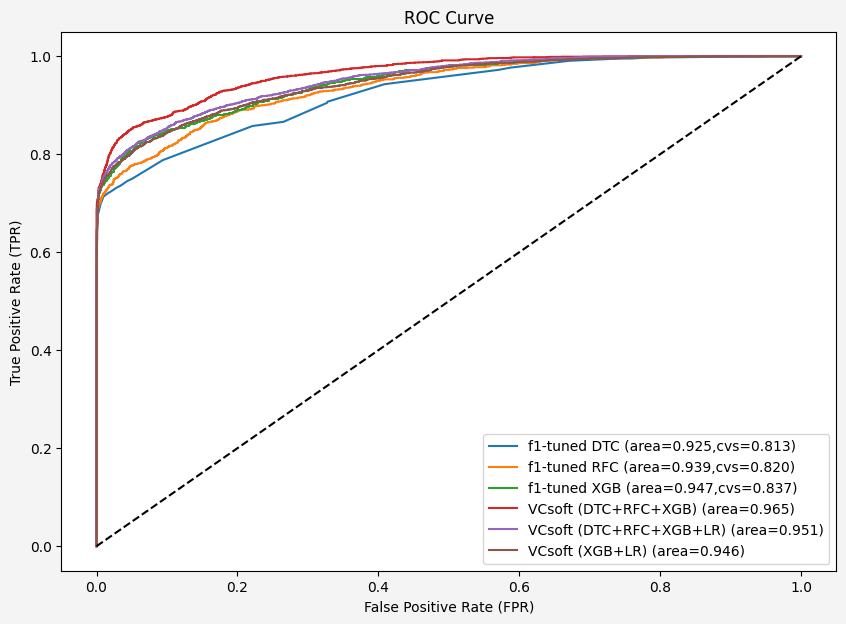

In [350]:
plt.figure(figsize=[10,7], facecolor='#F4F4F4')

#f1-tuned KNN
#plot_roc_from_tuned(filename='dumped/knn_gs_f1__unbalanced_set__tune1.joblib', label='f1-tuned KNN', X=X_val_processed, y=y_val)

#f1-tuned LR
#plot_roc_from_tuned(filename='dumped/lr_gs_f1__unbalanced_set__tune2.joblib', label='f1-tuned LR', X=X_val_processed, y=y_val)

#f1-tuned DTC
plot_roc_from_tuned(filename='dumped/dtc_gs_f1__unbalanced_set__tune3.joblib', label='f1-tuned DTC', X=X_val_processed, y=y_val)

#f1-tuned RFC
plot_roc_from_tuned(filename='dumped/rfc_gs_f1__unbalanced_set__tune3.joblib', label='f1-tuned RFC', X=X_val_processed, y=y_val)

#f1-tuned XGB
plot_roc_from_tuned(filename='dumped/xgb_gs_f1__unbalanced_set__tune2.joblib', label='f1-tuned XGB', X=X_val_processed, y=y_val)

#f1-tuned VCsoft
loaded = load('dumped/vc_soft__unbalanced_set_1.joblib')
model = loaded['model']
x = loaded['x']
fpr, tpr, ts = roc_curve(y_true=y, y_score=model.predict_proba(x)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='VCsoft (DTC+RFC+XGB) (area={:.3f})'.format(roc_auc))

#f1-tuned VCsoft with Logistic Regression
loaded = load('dumped/vc_soft_lr__unbalanced_set_1.joblib')
model = loaded['model']
x = loaded['x']
fpr, tpr, ts = roc_curve(y_true=y, y_score=model.predict_proba(x)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='VCsoft (DTC+RFC+XGB+LR) (area={:.3f})'.format(roc_auc))

#f1-tuned VCsoft with only XGB and LR
loaded = load('dumped/vc_soft_red__unbalanced_set_1.joblib')
model = loaded['model']
x = loaded['x']
fpr, tpr, ts = roc_curve(y_true=y, y_score=model.predict_proba(x)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='VCsoft (XGB+LR) (area={:.3f})'.format(roc_auc))


plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Performance visualization

I would like to show some graphical comparisons between the evaluated models.

In [351]:
#load the models
lr = load("dumped/lr_gs_f1__unbalanced_set__tune2.joblib")
knn = load("dumped/knn_gs_f1__unbalanced_set__tune1.joblib")
dtc = load('dumped/dtc_gs_f1__unbalanced_set__tune3.joblib')
rfc = load('dumped/rfc_gs_f1__unbalanced_set__tune3.joblib')
xgc = load('dumped/xgb_gs_f1__unbalanced_set__tune2.joblib')
vcs_lr = load('dumped/vc_soft_lr__unbalanced_set_1.joblib')
vcs = load('dumped/vc_soft__unbalanced_set_1.joblib')
vcs_red = load('dumped/vc_soft_red__unbalanced_set_1.joblib')
models = [lr['model'].best_estimator_, knn['model'].best_estimator_, dtc['model'].best_estimator_, rfc['model'].best_estimator_, xgc['model'].best_estimator_, vcs_lr['model'], vcs['model'], vcs_red['model']]
labels = ['LogRegr', 'KNN', 'DTC', 'RFC', 'XGB', 'VCS(DTC+RFC+XGB+LR)', 'VCS(DTC+RFC+XGB)', 'VCS(XGB+LR)']
colors = cm.viridis([i / 8 for i in range(9)])

In [352]:
#models = [lr['model'].best_estimator_, knn['model'].best_estimator_, dtc['model'].best_estimator_, rfc['model'].best_estimator_, xgc['model'].best_estimator_]
#labels = ['LogRegr', 'KNN', 'DTC', 'RFC', 'XGB']
#colors = cm.viridis([i / 5 for i in range(6)])

In [353]:
#prepare scores lists
accuracy_list = np.array([accuracy_score(y_true=y_val, y_pred=model.predict(X_val_processed)) for model in models])
f1_list = np.array([f1_score(y_true=y_val, y_pred=model.predict(X_val_processed)) for model in models])
precision_list = np.array([precision_score(y_true=y_val, y_pred=model.predict(X_val_processed)) for model in models])
recall_list = np.array([recall_score(y_true=y_val, y_pred=model.predict(X_val_processed)) for model in models])

Text(0.5, 0, 'Recall score')

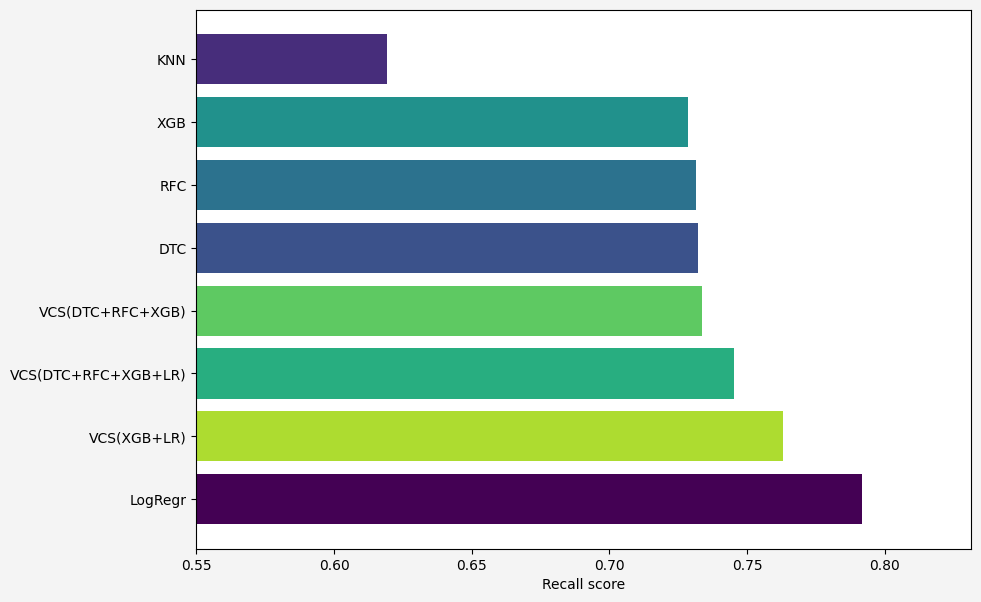

In [354]:
sort = np.argsort(recall_list)[::-1]
plt.figure(figsize=[10,7], facecolor='#F4F4F4')
plt.barh([labels[i] for i in sort], recall_list[sort], color=[colors[i] for i in sort])
plt.xlim(0.55)
plt.xlabel('Recall score')

Text(0.5, 0, 'Precision score')

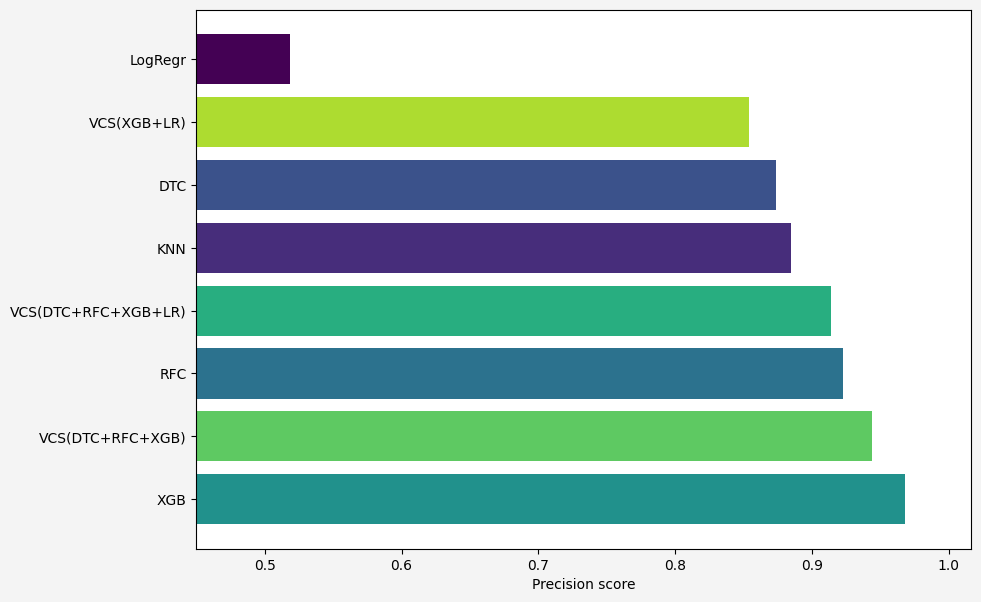

In [355]:
sort = np.argsort(precision_list)[::-1]
plt.figure(figsize=[10,7], facecolor='#F4F4F4')
plt.barh([labels[i] for i in sort], precision_list[sort], color=[colors[i] for i in sort])
plt.xlim(0.45)
plt.xlabel('Precision score')

Text(0.5, 0, 'Accuracy score')

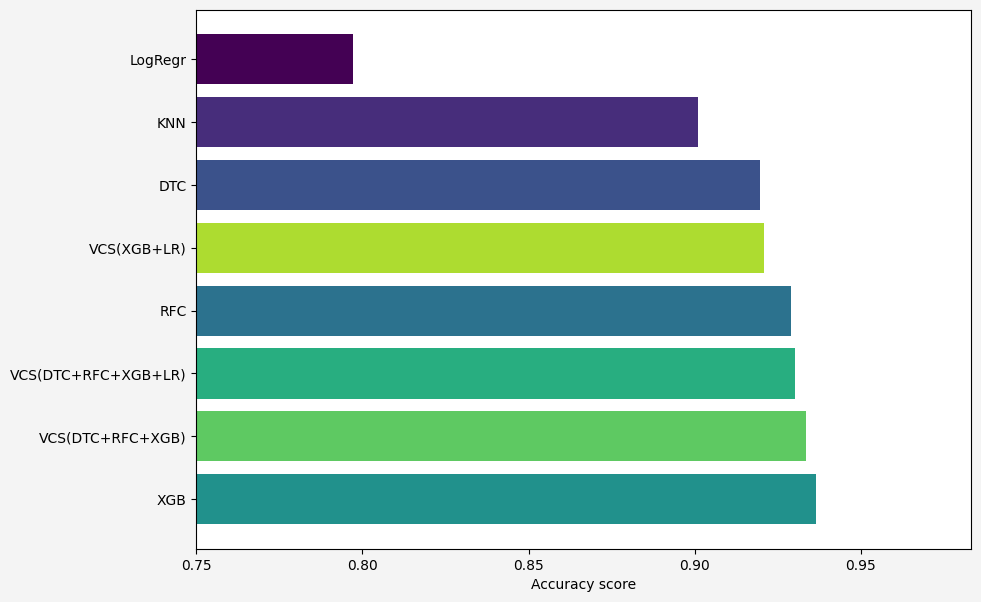

In [356]:
sort = np.argsort(accuracy_list)[::-1]
plt.figure(figsize=[10,7], facecolor='#F4F4F4')
plt.barh([labels[i] for i in sort], accuracy_list[sort], color=[colors[i] for i in sort])
plt.xlim(0.75)
plt.xlabel('Accuracy score')

Text(0.5, 0, 'F1 score')

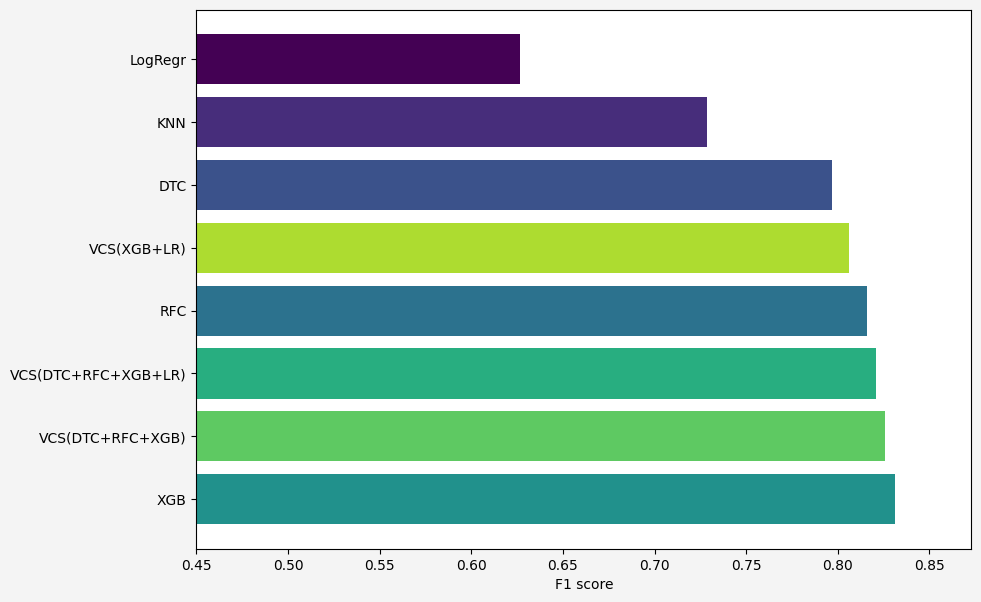

In [357]:
sort = np.argsort(f1_list)[::-1]
plt.figure(figsize=[10,7], facecolor='#F4F4F4')
plt.barh([labels[i] for i in sort], f1_list[sort], color=[colors[i] for i in sort])
plt.xlim(0.45)
plt.xlabel('F1 score')

Text(0.5, 0, 'Recall')

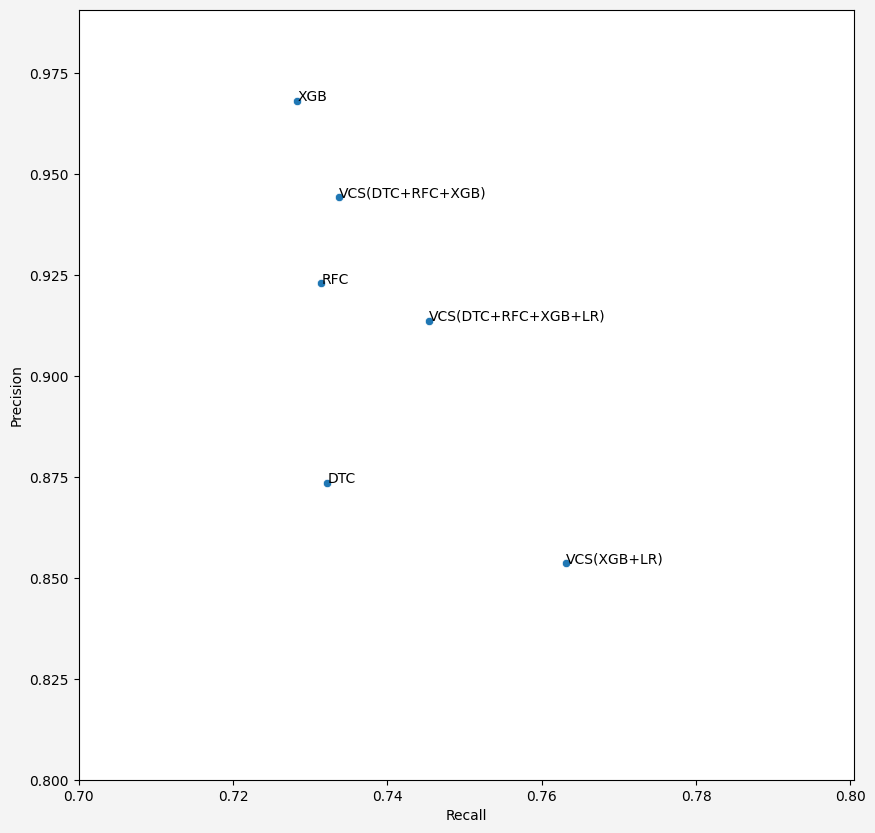

In [358]:
plt.figure(figsize=[10,10], facecolor='#F4F4F4')
sns.scatterplot(x=recall_list, y=precision_list)
for i in range(0,len(recall_list)):
    plt.annotate(labels[i], (recall_list[i], precision_list[i]))
plt.ylim(0.80)
plt.xlim(0.7)
plt.ylabel('Precision')
plt.xlabel('Recall')
#plt.title('Comparision of precision and recall among best models')

In general and overall, XGBoost appears to be the best model, but the differences with Random Forest and the various Voting Classifiers are quite small. 

To effectively determine which of these models to propose to the client, more information is needed regarding the specific goals, costs, and business strategies involved.

Finally, I choose to showcase the Voting Classifier that includes XGBoost (XGB), Decision Tree Classifier (DTC), Random Forest Classifier (RFC), and Logistic Regression. This choice is made because it represents a good overall compromise.

# Model testing

In [359]:
#saving VCS including LR as final model
full_processor.fit(X_devtrain)
final_model = Pipeline(
    [
        ('preprocessor', full_processor),
        ('model', load('dumped/vc_soft_lr__unbalanced_set_1.joblib')['model'])
    ]
)
dump(final_model, 'dumped/final_model.joblib')

['dumped/final_model.joblib']

In [360]:
#finally evaluating on test set
model = load('dumped/final_model.joblib')
predictions = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      6717
           1       0.91      0.73      0.81      1871

    accuracy                           0.92      8588
   macro avg       0.92      0.85      0.88      8588
weighted avg       0.92      0.92      0.92      8588



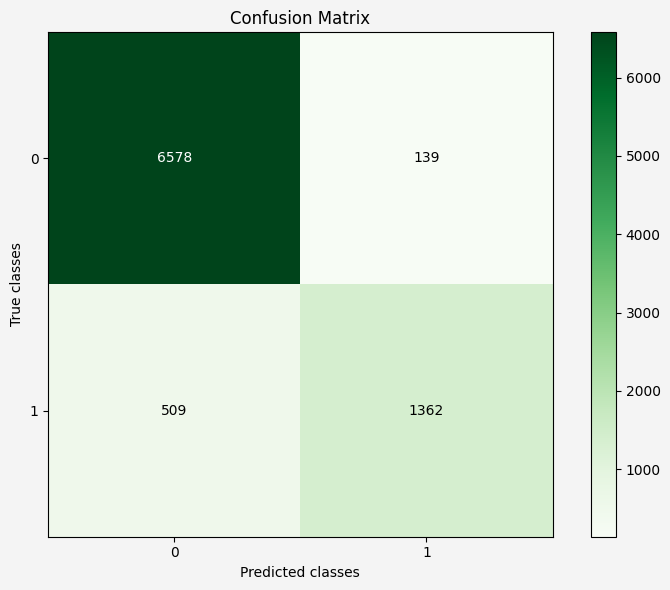

In [361]:
print(classification_report(y_true=y_test, y_pred=predictions))
plot_confusion_matrix(y_true=y_test, y_pred=predictions)

## Feature importances

Text(0.5, 1.0, 'Feature importance for XGBoost classifier')

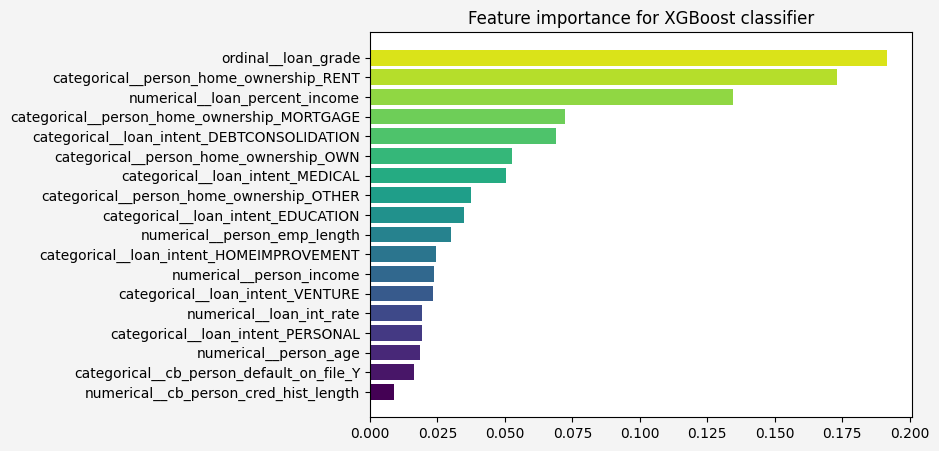

In [362]:
fn = model[:-1].get_feature_names_out()
fi = model.steps[1][1].estimators_[3].feature_importances_
sort = np.argsort(fi)
plt.figure(figsize=[7,5], facecolor='#F4F4F4')
plt.barh([fn[i] for i in sort], fi[sort], color=cm.viridis([i / len(sort) for i in range(len(sort)+1)]))
plt.title('Feature importance for XGBoost classifier')

Looking at the feature importance of the XGBoost model (part of the final Voting Classifier model), we see some confirmations of what was expected, but also some surprises. 
- The high importance of loan grade and loan percent income does not come as a surprise. 
- However, it is surprising to see the low importance of historical default and loan interest rate.

# Conclusions

1. Through tuning and ensemble methods, most of the initial issues with overfitting and imbalance have been addressed.
2. Unfortunately, the class imbalance remains an inherent problem in the dataset, leading to only modest recall performance. Further techniques could be employed to address this, including:
   - More thorough parameter tuning using different metrics, possibly customized for the specific problem.
   - Partial rebalancing, such as downsampling the majority class to achieve a ratio different from 1:1 but still lower than the current imbalance.
   - Utilizing algorithms and libraries specifically engineered to handle imbalanced classes.
3. The data cleaning process can be further refined, although the presence of outliers is minimal.
4. Conducting an in-depth feature importance analysis could help identify and remove certain features that introduce noise and disrupt algorithms such as Logistic Regression.
5. As shown in the next section, it might be possible to adjust the threshold of probabilistic algorithms to find different trade-offs between precision and recall.

# Extra: is it possibile to estimate default risk?

This is a little extra that I thought could be interesting. 

By plotting the distributions of predicted probabilities and differentiating them based on the actual classes, you obtain the graph shown below.

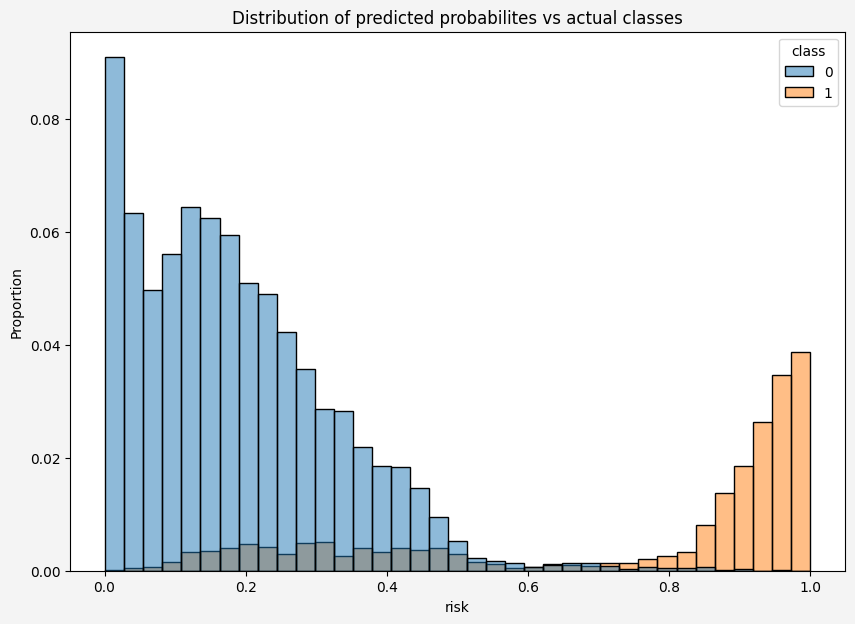

In [363]:
model = load('dumped/final_model.joblib')
probabilities = model['model'].predict_proba(full_processor.transform(X_test))
df_prob = pd.DataFrame(probabilities[:,1], columns=['risk'])
df_prob['class'] = y_test
plt.figure(figsize=[10,7], facecolor='#F4F4F4')
plt.title('Distribution of predicted probabilites vs actual classes')
sns.histplot(data=df_prob, x='risk', hue='class', common_norm=True, stat='proportion');

The x-axis represents the predicted probabilities from the model, which can be used as an estimate of the risk of a customer defaulting.

Furthermore, from this graph (as well as the ROC curve), it is also possible to imagine adjusting the prediction threshold forward or backward from 0.5, gaining recall at the expense of precision or vice versa, based on the client's requirements.

Moreover, the client could also establish a central range in which to identify at-risk customers and expand the classification into three clusters, for example:

Text(0.9, 0.8, 'Default')

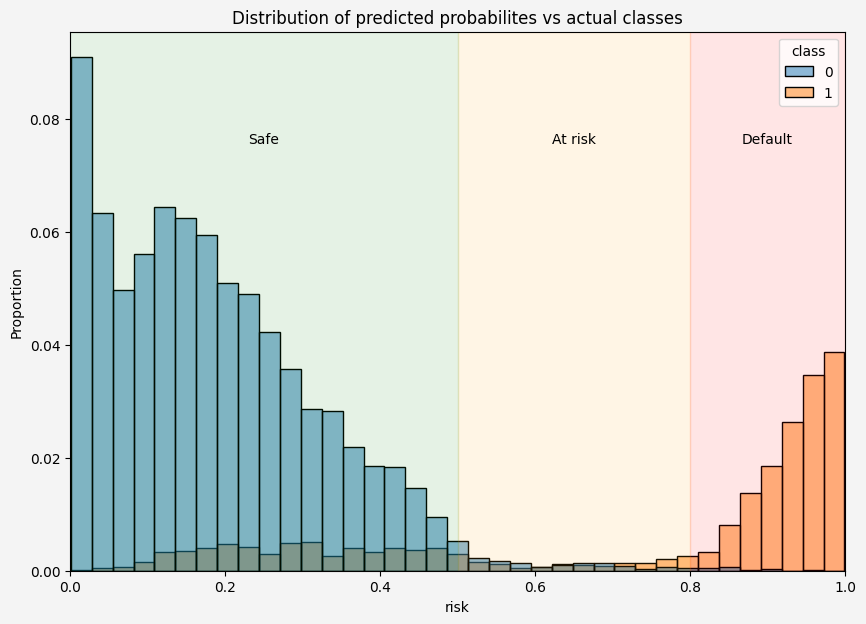

In [364]:
model = load('dumped/final_model.joblib')
probabilities = model['model'].predict_proba(full_processor.transform(X_test))
df_prob = pd.DataFrame(probabilities[:,1], columns=['risk'])
df_prob['class'] = y_test
plt.figure(figsize=[10,7], facecolor='#F4F4F4')
plt.title('Distribution of predicted probabilites vs actual classes')
sns.histplot(data=df_prob, x='risk', hue='class', common_norm=True, stat='proportion')
plt.axvspan(0, 0.5, color='g', alpha=0.1)
plt.axvspan(0.5, 0.8, color='orange', alpha=0.1)
plt.axvspan(0.8, 1, color='r', alpha=0.1)
plt.xlim(0,1)
plt.text(0.25,0.8, 'Safe', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.65,0.8, 'At risk', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.9,0.8, 'Default', ha='center', va='center', transform=plt.gca().transAxes)